# SWH LCA Project Results Visualisation

This notebook contains data processing and visualization code for analyzing a Life Cycle Assessment (LCA) dataset of Space and Water Heating (SWH) technologies in New Zealand. The goal is to generate actionable insights from the integrated study results.

## Exploratory Data Analysis

We begin by loading and exploring the dataset, which integrates results from:
1. **Thermal modeling** of space and water heating (SWH) systems  
2. **Temporal power dispatch modeling**  
3. **Environmental Product Declaration (EPD) analysis** of embodied emissions  

The dataset contains lifetime emissions (operational + embodied) for household scenarios defined by:

#### Key Scenario Parameters
| Category               | Variables                                                                 |
|------------------------|--------------------------------------------------------------------------|
| **House Type**         | Modern post-1978 (`Mod`), State house (`Mass`)                          |
| **Insulation**         | Nominal (`Nom`), H1-standard minimum (`H1`)                             |
| **Schedule**           | Realistic (`Real`), Idealistic (`Ideal`)                                |
| **Climate**            | Auckland (`AK`), Christchurch (`CH`)                                    |
| **Occupancy**          | 1-5 occupants                                                           |
| **Space Heating**      | Resistive (`R`), ASHP (`HP`), Hybrid (`HPl_Rb`), Hydronic (`HYD200-1000`) |
| **Water Heating**      | Resistive (`R`/`Ro`), ASHP (`HP`/`HPo`), Hydronic (`HYD200-1000`)       |
| **Control Strategy**   | None (`C0`), Peak shaving (`Cpeak`), Renewable-following (`Crenew`)     |
| **Hydrology**          | High inflows (`Hhigh`), Low inflows (`Hlow`)                            |

In [63]:
library(tidyverse) %>% suppressMessages()
options(warn = -1)
household_lifetime_Call <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/household_lifetime_Call.csv") %>% suppressMessages()
household_lifetime_Call <- household_lifetime_Call %>% 
    mutate(SH_DW_code = factor(SH_DW_code, levels = c("HP-HP", "HP-HPo", "HP-R", "HP-Ro", "HPl_Rb-HP", "HPl_Rb-HPo",
                                                      "HPl_Rb-R", "HPl_Rb-Ro", "HYD200-HYD200", "HYD500-HYD500", "HYD1000-HYD1000", 
                                                      "R-HP", "R-HPo", "R-R", "R-Ro")))
#household_lifetime_Call %>% summary()

### Discussion

The dataset comprises **6,624 scenarios**, though not all possible combinations are represented due to system constraints:  
- Hydronic systems are only modeled for households with **>3 occupants**  
- Non-hydronic systems have additional end-use specifications  

#### Key Variables  
| Variable                | Description                                                                 |
|-------------------------|----------------------------------------------------------------------------|
| `P_annual_kWh_life`     | Lifetime electricity consumption                                           |
| `Operation_Life`        | Operational emissions over system lifetime                                 |
| `Embodied_life`         | **Aggregated embodied emissions** from:                                    |
|                         | 1. Manufacture 2. Distribution 3. Installation 4. End-of-Life (EOL) 5. Other (B2-B5)       |

#### System-Specific Details  
- **Non-hydronic setups**: Include breakdowns by end-use (space vs. water heating)  
- **Hydronic setups**: Limited to high-occupancy scenarios

## Regression Analysis
We conducted regression analysis to quantify the impact of key variables on lifetime emissions across Space and Water Heating (SWH) technology configurations.  
#### Model setup  
- **Dependent Variable**:  
  `Total_Lifetime_Emissions` (sum of operational and embodied emissions)  
- **Independent Variables**:  
  - Categorical: House type, insulation, schedule, climate, heating system type, location, control signal, hydrological condition  
  - Continuous: Occupancy, annual energy use  
- **Model Type**:  
  Linear regression   

The regression approach allows to identify **statistically significant** drivers of emissions, and compare effect sizes across technology types 

In [2]:
household_lifetime_Call_summary <- household_lifetime_Call %>% 
group_by(house_type, Loc_code, Hydro_resource, CS_code, schedule, insulation, SH_DW_code, Occ_code) %>%
  summarise(Embodied = sum(Embodied_life),
            Operation = sum(Operation_life)) %>% suppressMessages() %>%
  ungroup() %>%
  mutate(Total = Embodied + Operation)
# Select numeric and categorical predictors + targets
predictors <- c("house_type", "insulation", "schedule", "Loc_code", "Hydro_resource", "SH_DW_code", "Occ_code", "CS_code")
targets <- c("Embodied","Operation","Total")
# Pre-processing character to factor 
household_regression <- household_lifetime_Call_summary %>%
  select(all_of(c(predictors, targets))) %>%
  mutate(across(where(is.character), as.factor))
# Fit linear model
lm_total <- lm(Total ~ ., data=household_regression %>% select(-Operation, -Embodied))
summary(lm_total)


Call:
lm(formula = Total ~ ., data = household_regression %>% select(-Operation, 
    -Embodied))

Residuals:
    Min      1Q  Median      3Q     Max 
-4916.0 -1464.7  -302.4  1162.6  9610.8 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               -705.862    134.787  -5.237 1.68e-07 ***
house_typeMod             4008.218     53.146  75.419  < 2e-16 ***
insulationNom             2963.443     53.146  55.760  < 2e-16 ***
scheduleReal              -872.854     53.146 -16.424  < 2e-16 ***
Loc_codeCH                5349.577     53.146 100.658  < 2e-16 ***
Hydro_resourceHlow        1986.127     53.146  37.371  < 2e-16 ***
SH_DW_codeHP-HPo           153.138    139.603   1.097  0.27270    
SH_DW_codeHP-R            1097.808    139.603   7.864 4.32e-15 ***
SH_DW_codeHP-Ro           1256.475    139.603   9.000  < 2e-16 ***
SH_DW_codeHPl_Rb-HP        610.633    139.603   4.374 1.24e-05 ***
SH_DW_codeHPl_Rb-HPo       763.771    139.603   5.471 4

#### Visualisation of a coefficients plot with marginal effects
The following plot shows the results of the regression estimates. The reference or control variables are: Location == 'AK', SH_DW_code == 'HP-HP, insulation == 'H1', Hydro_resource == 'Hhigh', CS_code == 'C0', and schedule == 'Ideal'. 

In [3]:
library(broom.helpers)
library(ggplot2)
# Tidy up model coefficients and confidence intervals
coef_df <- tidy_plus_plus(lm_total)
coef_df <- coef_df %>% 
  filter(!is.na(statistic)) %>% 
  mutate(term_clean = ifelse(variable == label, variable,paste0(variable," = ",label)))


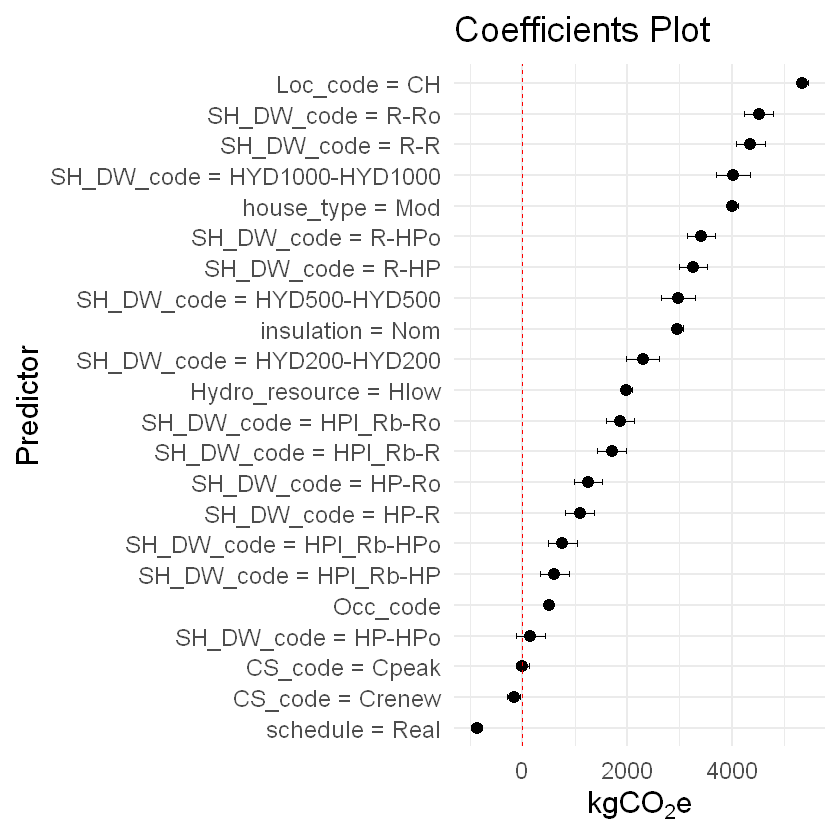

In [4]:
ggplot(coef_df, aes(x = reorder(term_clean, estimate), y = estimate)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  coord_flip() +
  labs(
    x = "Predictor",
    y = expression(kgCO[2]*e),
    title = "Coefficients Plot"  
  ) +
  theme_minimal(base_size = 18)

### Discussion
Our regression analysis reveals the following key drivers of lifetime CO₂ emissions, ranked by effect size and statistical significance (all p < 0.001):
#### Most Impactful Variables
| Variable                  | Effect Size (kg CO₂e) | Interpretation                                                                 |
|---------------------------|-----------------------|-------------------------------------------------------------------------------|
| **Location (CH vs AK)**   | +5334.11             | Christchurch homes emit **5300+ kg CO₂e more** than Auckland homes            |
| **House Type (Mod vs Mass)** | +3989.27         | Modern houses emit **~4000 kg CO₂e more** than state houses                   |
| **Insulation (Nom vs H1)** | +2944.08           | Nominal insulation adds **2900+ kg CO₂e** vs H1-standard                      |
| **Hydrology (Low vs High)** | +1986.13          | Low-hydro years increase emissions by **~2000 kg CO₂e**                        |
| **Resistive Heating**      | +4398.79            | Resistive systems emit **4400+ kg CO₂e more** than heat pumps (reference)     |

#### Key Implications
1. **Geographic Disparity**:  
   - The >5-tonne location effect suggests climate zone is the **strongest predictor** of emissions.  
2. **Building Standards Matter**:  
   - Houses with nominal insulation may emit **~3000 kg CO₂e more** than well-insulated ones.  
3. **Technology Choice**:  
   - Resistive heating systems have the bigger carbon footprint.

## Impact of Location, House Type, and Insulation
This part of the analysis is based on the following considerations:
1. **Data Filtering**  
   - Excluded low-occupancy scenarios (<3 occupants) to ensure comparability  
     *(Rationale: Hydronic systems are only viable for households with ≥3 occupants)*  
2. **Variable Selection**  
   Focused on the most impactful predictors from regression analysis:  
   - **Location** (Auckland vs. Christchurch)  
   - **House Type** (Modern vs. State)  
   - **Insulation** (Nominal vs. H1-standard)  
3. **Aggregation Approach**  
   - Grouped by technology setup → Calculated mean lifetime emissions  

The following plot reveals:  
1. **Geographic Disparities**  
   - Christchurch (`CH`) emissions >> Auckland (`AK`) due to heating demand  
2. **Building Envelope Effects**  
   - Nominal (`HP`) insulation has highest emissions  
3. **Technology setups**  
   - Key comparison: Heat pumps (`HP`) vs. resistive (`R`) vs. hydronic (`HYD`)  

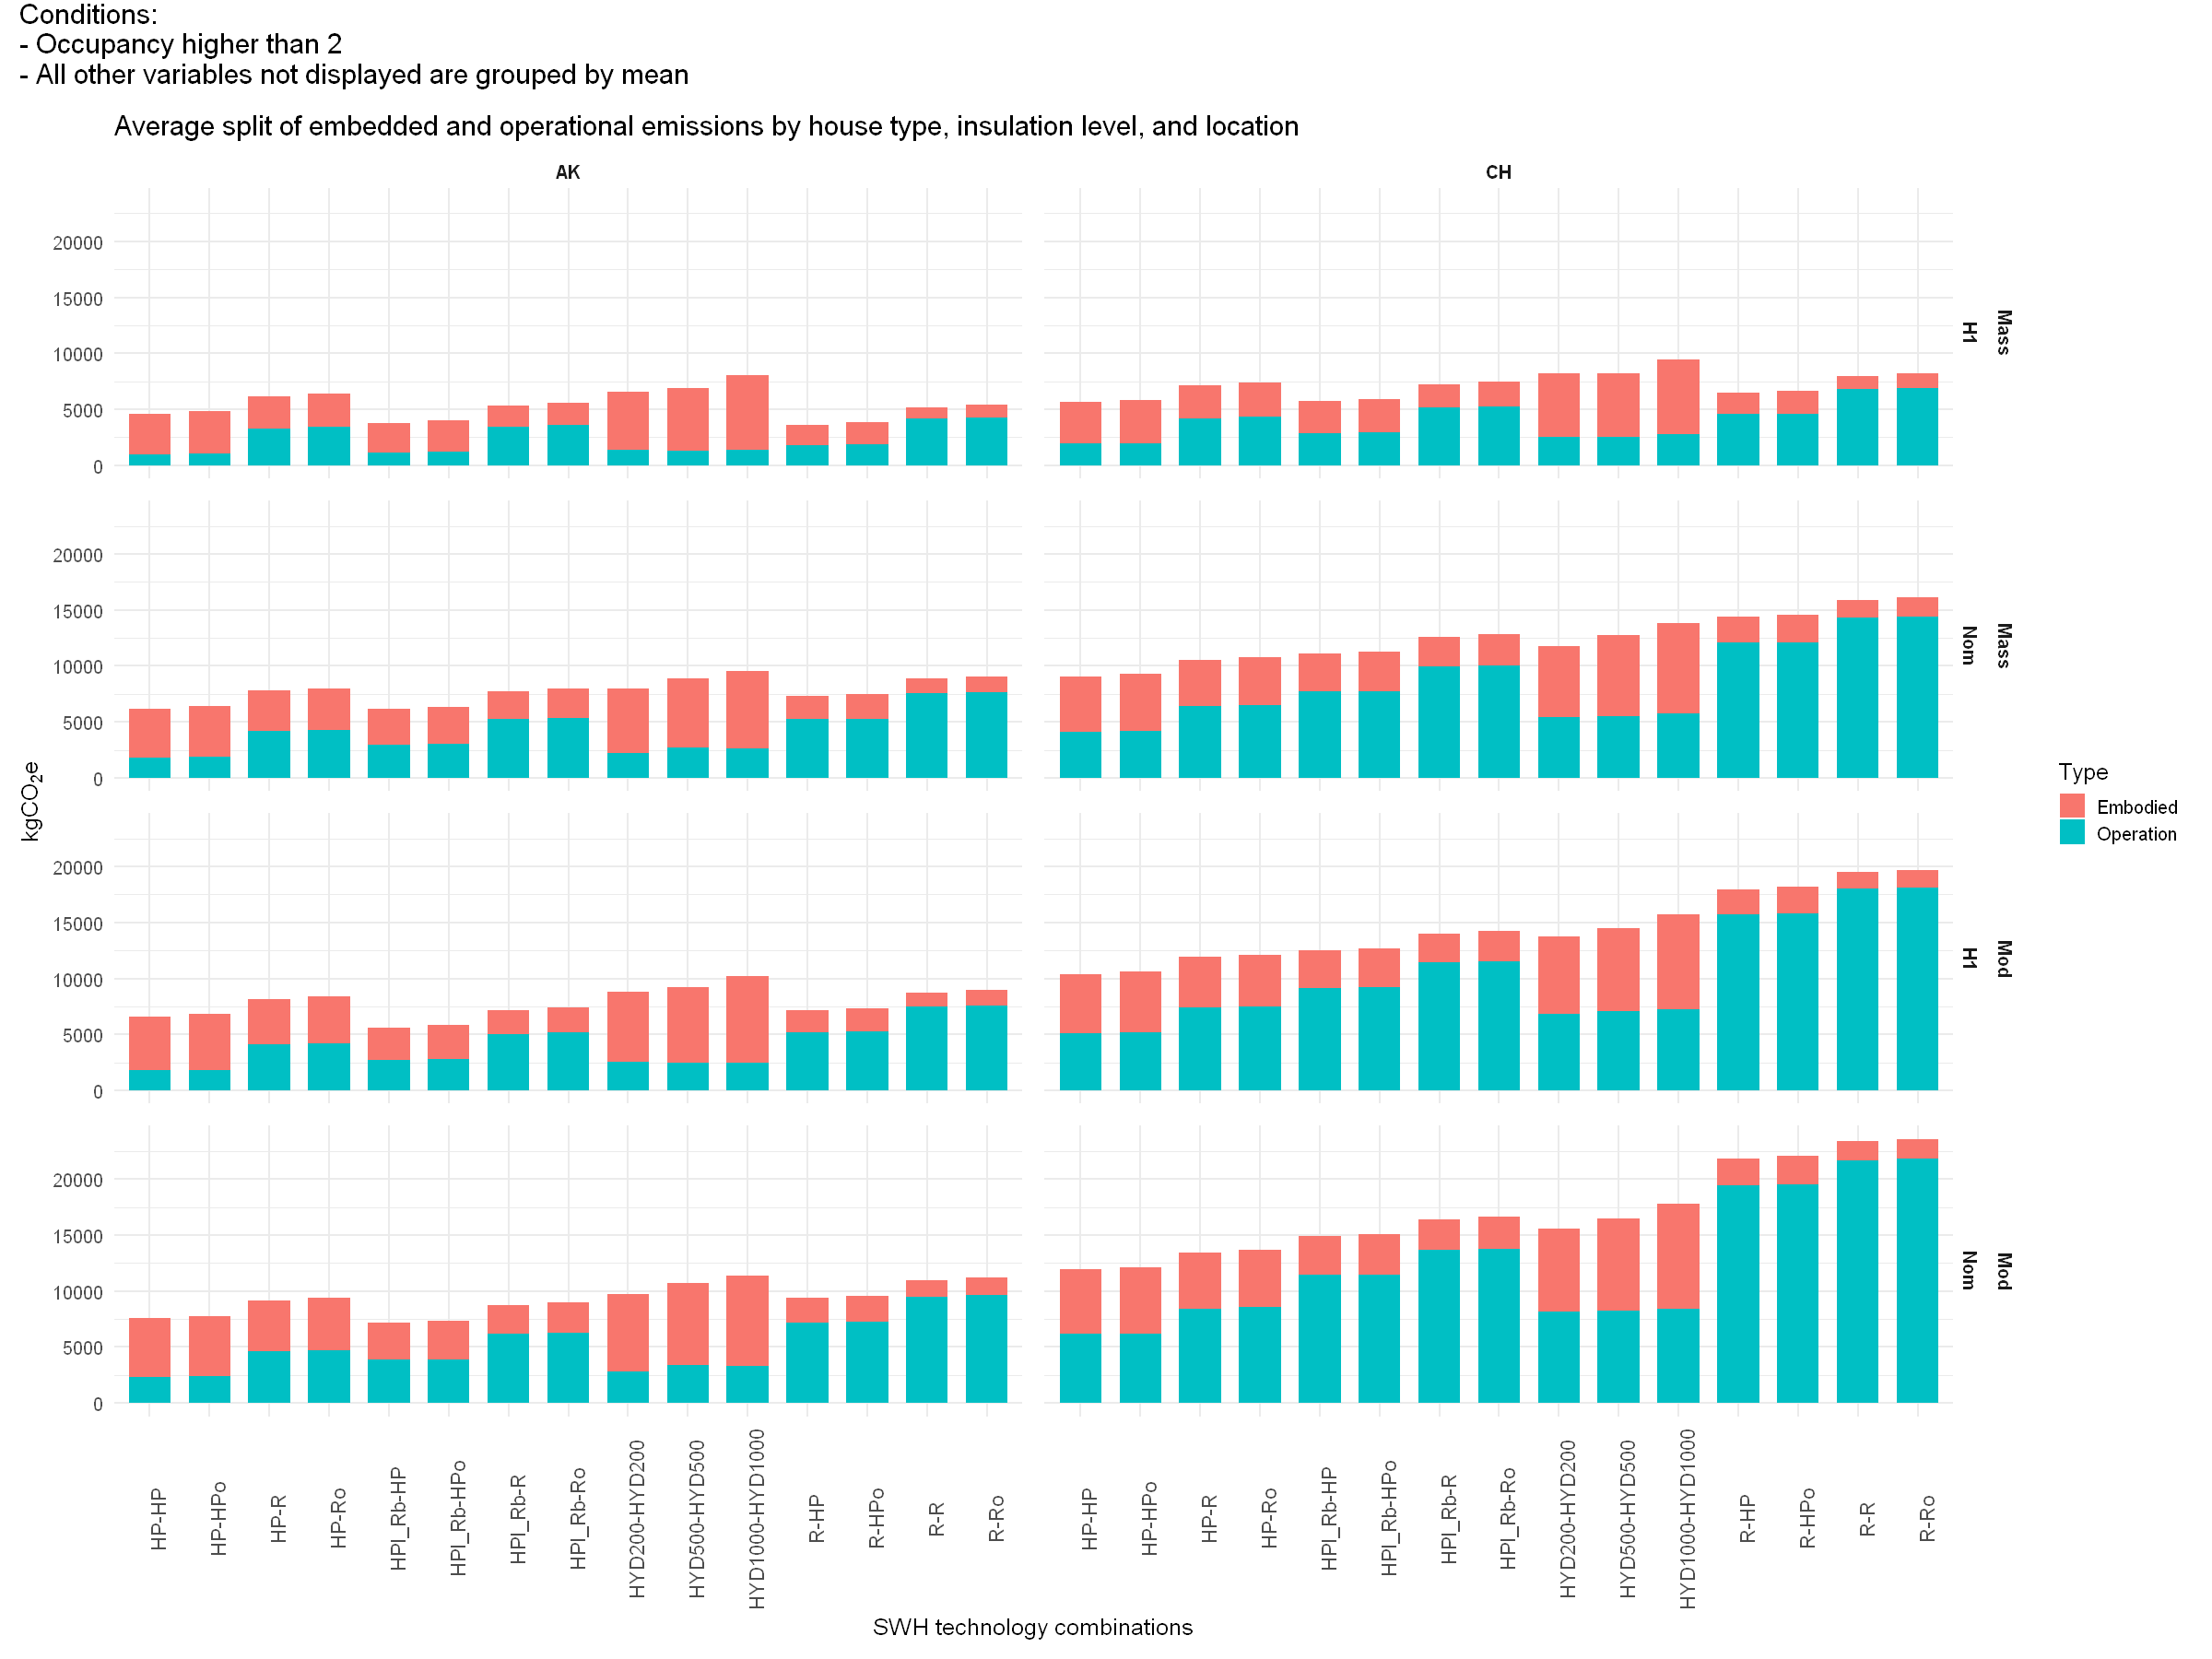

In [5]:
library(patchwork)
household_lifetime_Call_location <- household_lifetime_Call %>% filter(Occ_code > 2) %>%
group_by(Loc_code, house_type, insulation, SH_DW_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_location <- household_lifetime_Call_location %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")
# Plot
options(repr.plot.width=20, repr.plot.height=15)
emissions_plot <- ggplot(plot_location, aes(x = SH_DW_code, y = Emissions, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  facet_grid(house_type + insulation ~ Loc_code) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH technology combinations",
       y = expression(kgCO[2]*e),
       title = "Average split of embedded and operational emissions by house type, insulation level, and location") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 13),
    strip.text = element_text(face = "bold"),
    panel.spacing = unit(1, "lines")
  )
emissions_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy higher than 2\n- All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
#### Key Findings

1. **Operational Emissions Dominate**  
   - Differences in total emissions across all SWH technologies are **primarily driven by operational components** (energy use during operation).  
   - *Exception*: Hydronic systems show a more balanced operational/embodied split.  

2. **Geographic Impact**  
   - Christchurch (CH) systems exhibit **higher lifetime emissions** than Auckland (AK) across all setups, which is owed to the difference in climate.  
3. **House Type Effect**  
   | House Type | Bedrooms | Avg. Added Emissions (vs Mass) | Primary Contributor |  
   |------------|----------|-------------------------------|---------------------|  
   | Modern (Mod) | 4       | +3989 kg CO₂e                  | Larger space heating demand |  
   | Mass (Ref.) | 2       | Baseline                       | -                   |  

   - The **+3989 kg CO₂e** estimate (from regression) aligns with observed emission differences.  

4. **Technology-Specific Trends**  
   - **Hydronic systems**: Embodied emissions play a larger role (~50-75% share) due to:  
     - Complex manufacturing  
     - High-material-use components, specially in buffer tanks  

#### Policy Implications  
- **Retrofitting priorities**: Houses in Christchurch offer the highest potential savings.  
- **Technology selection**: Heat pumps outperform resistive systems in all scenarios.  

At this stage, variables such as control signal, occupancy, and operation schedule have been aggregated into the analysis. In the next section, however, we will examine their individual impacts in isolation.

## Impact of Electricity Emission Factor

- **Operational emissions** are highly sensitive to the electricity emission factor (EF), which varies temporally based on:
  - Grid demand patterns
  - Installed capacity mix
  - Renewable resource availability (especially hydro)

1. **Data Selection**:
   - Scenario: `C0` (no control signal)
   - Location: Christchurch only (*Higher operational emission share*)
   - Systems: Filtered to exclude oversized setups
   - Focus Technologies:
     - `HP-HP` (Full heat pump)
     - `R-R` (Full resistive)
     - `HPl_Rb-R` (Hybrid heat pump/resistive)
     - `HYD500-HYD500` (Mid-size hydronic)

2. **Temporal Analysis**:
   - Used annual EF time series accounting for:
     - Hydro inflow variability (`Hhigh` vs `Hlow`)
     - Power Demand-Generation capacity interaction

In [65]:
household_annual <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/household_year_C0.csv") %>%
    suppressMessages()
household_annual_summary <- household_annual %>% 
filter(Loc_code == 'CH', 
       year>2024, 
       Occ_code>2,
       SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD500-HYD500')) %>% 
mutate(Embodied = Manufacture + Distribution + Installation + EOL + Other) %>%
group_by(house_type, insulation, Hydro_resource, SH_DW_code, year) %>%
summarise(Embodied_annual = mean(Embodied),
          Operation_annual = mean(Operation)) %>% 
suppressMessages() %>%
ungroup()
# Reshape data to long format for ggplot2
household_annual_summary_long <- household_annual_summary %>%
  pivot_longer(cols = c(Embodied_annual, Operation_annual), names_to = "Type", values_to = "Emissions")

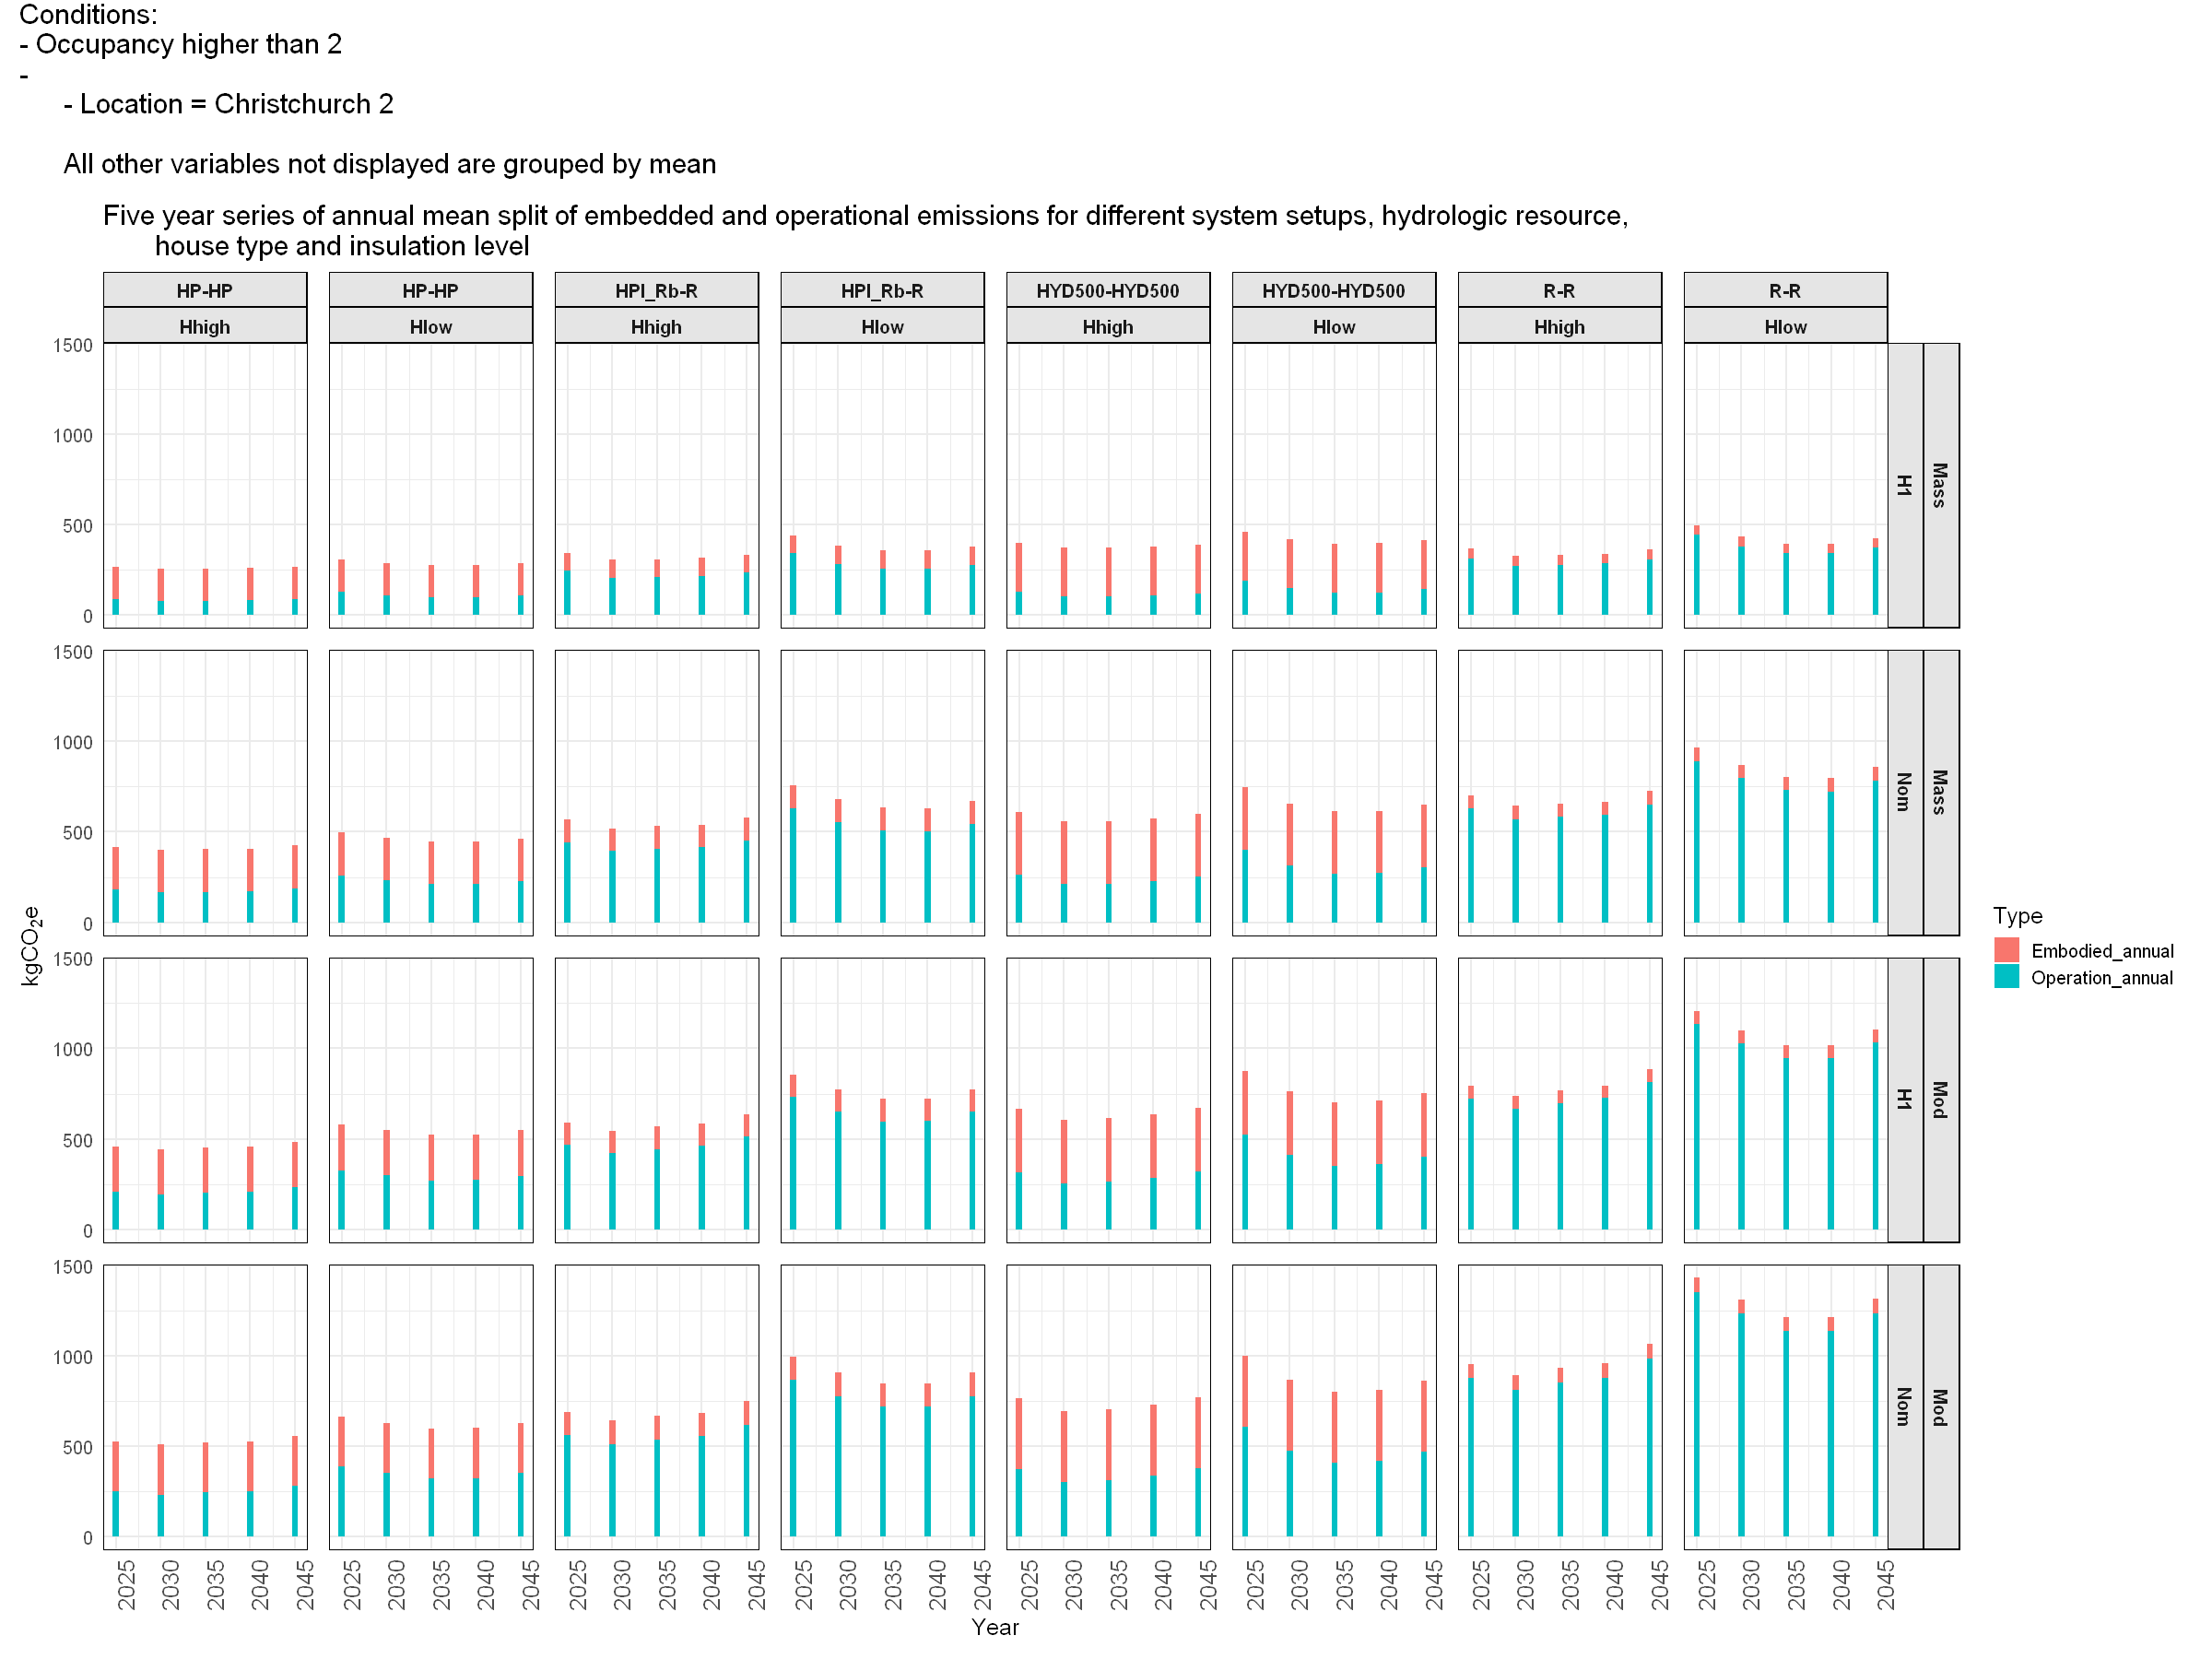

In [7]:
# Plot
options(repr.plot.width=20, repr.plot.height=15)
intensity_plot <- ggplot(household_annual_summary_long, aes(x = year, y = Emissions, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  facet_grid(house_type + insulation ~ SH_DW_code + Hydro_resource) +
  theme_minimal(base_size = 15) +
  labs(x = "Year",
       y = expression(kgCO[2]*e),
       title = "Five year series of annual split of embedded and operational emissions for different system setups, hydrologic resource,
       house type and insulation level") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    strip.text = element_text(face = "bold"),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines")
  )

intensity_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy higher than 2\n- 
      - Location = Christchurch 2\n
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )


### Discussion
It can be observed that in all cases, operational emissions initially decline until around 2035, after which they begin to increase. This pattern aligns with the electricity emission factor trend under the Reference scenario, where an increase in renewable power generation capacity is offset by a simultaneous rise in electricity demand. As a result, the trade-offs between clean supply and growing consumption lead to the observed emission trajectory. Additionally, emissions in the 'Hhigh' cases are consistently lower than those in the 'Hlow' cases, highlighting the strong dependency on hydrological resource availability.

## Impact of Control Signal on Direct Emissions
The previous plot analyzed the 'C0' (no control) scenario. A novel aspect of this study is investigating the interaction between thermal storage and control signals. Specifically, we examine hydronic scenarios where thermal storage is applied to both space and water heating systems.  
Hypothetically, appropriate control signals could:  
- Enable systems to prioritise operation when renewable generation share is high  
- Shift operation to off-peak times, potentially reducing indirect emissions from power system infrastructure  
For simplicity, the following analysis focuses on:  
- Location: Christchurch  
- Technology setups:  
  - HP-HP  
  - R-R  
  - HPl_Rb-R  
  - HYD200-HYD200  
  - HYD1000-HYD1000
- Realistic operation schedule
- High hydro inflows

In [8]:
household_lifetime_Call_CS_high <- household_lifetime_Call %>% 
filter(Occ_code > 2, 
       Loc_code == 'CH',
      SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000'),
      Hydro_resource == 'Hhigh',
      schedule == 'Real') %>%
group_by(house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_CS_high <- household_lifetime_Call_CS_high %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")
# Calculate base case emissions
base_CS_high <- plot_CS_high %>%
  filter(CS_code == 'C0') %>%
  select(house_type, insulation, SH_DW_code, Type, base_Emissions = Emissions)
# Join base emissions onto all CS_code values
plot_CS_diff_high <- plot_CS_high %>%
  left_join(base_CS_high, by = c("house_type", "insulation", "SH_DW_code", "Type")) %>%
  mutate(diff_base = Emissions - base_Emissions)

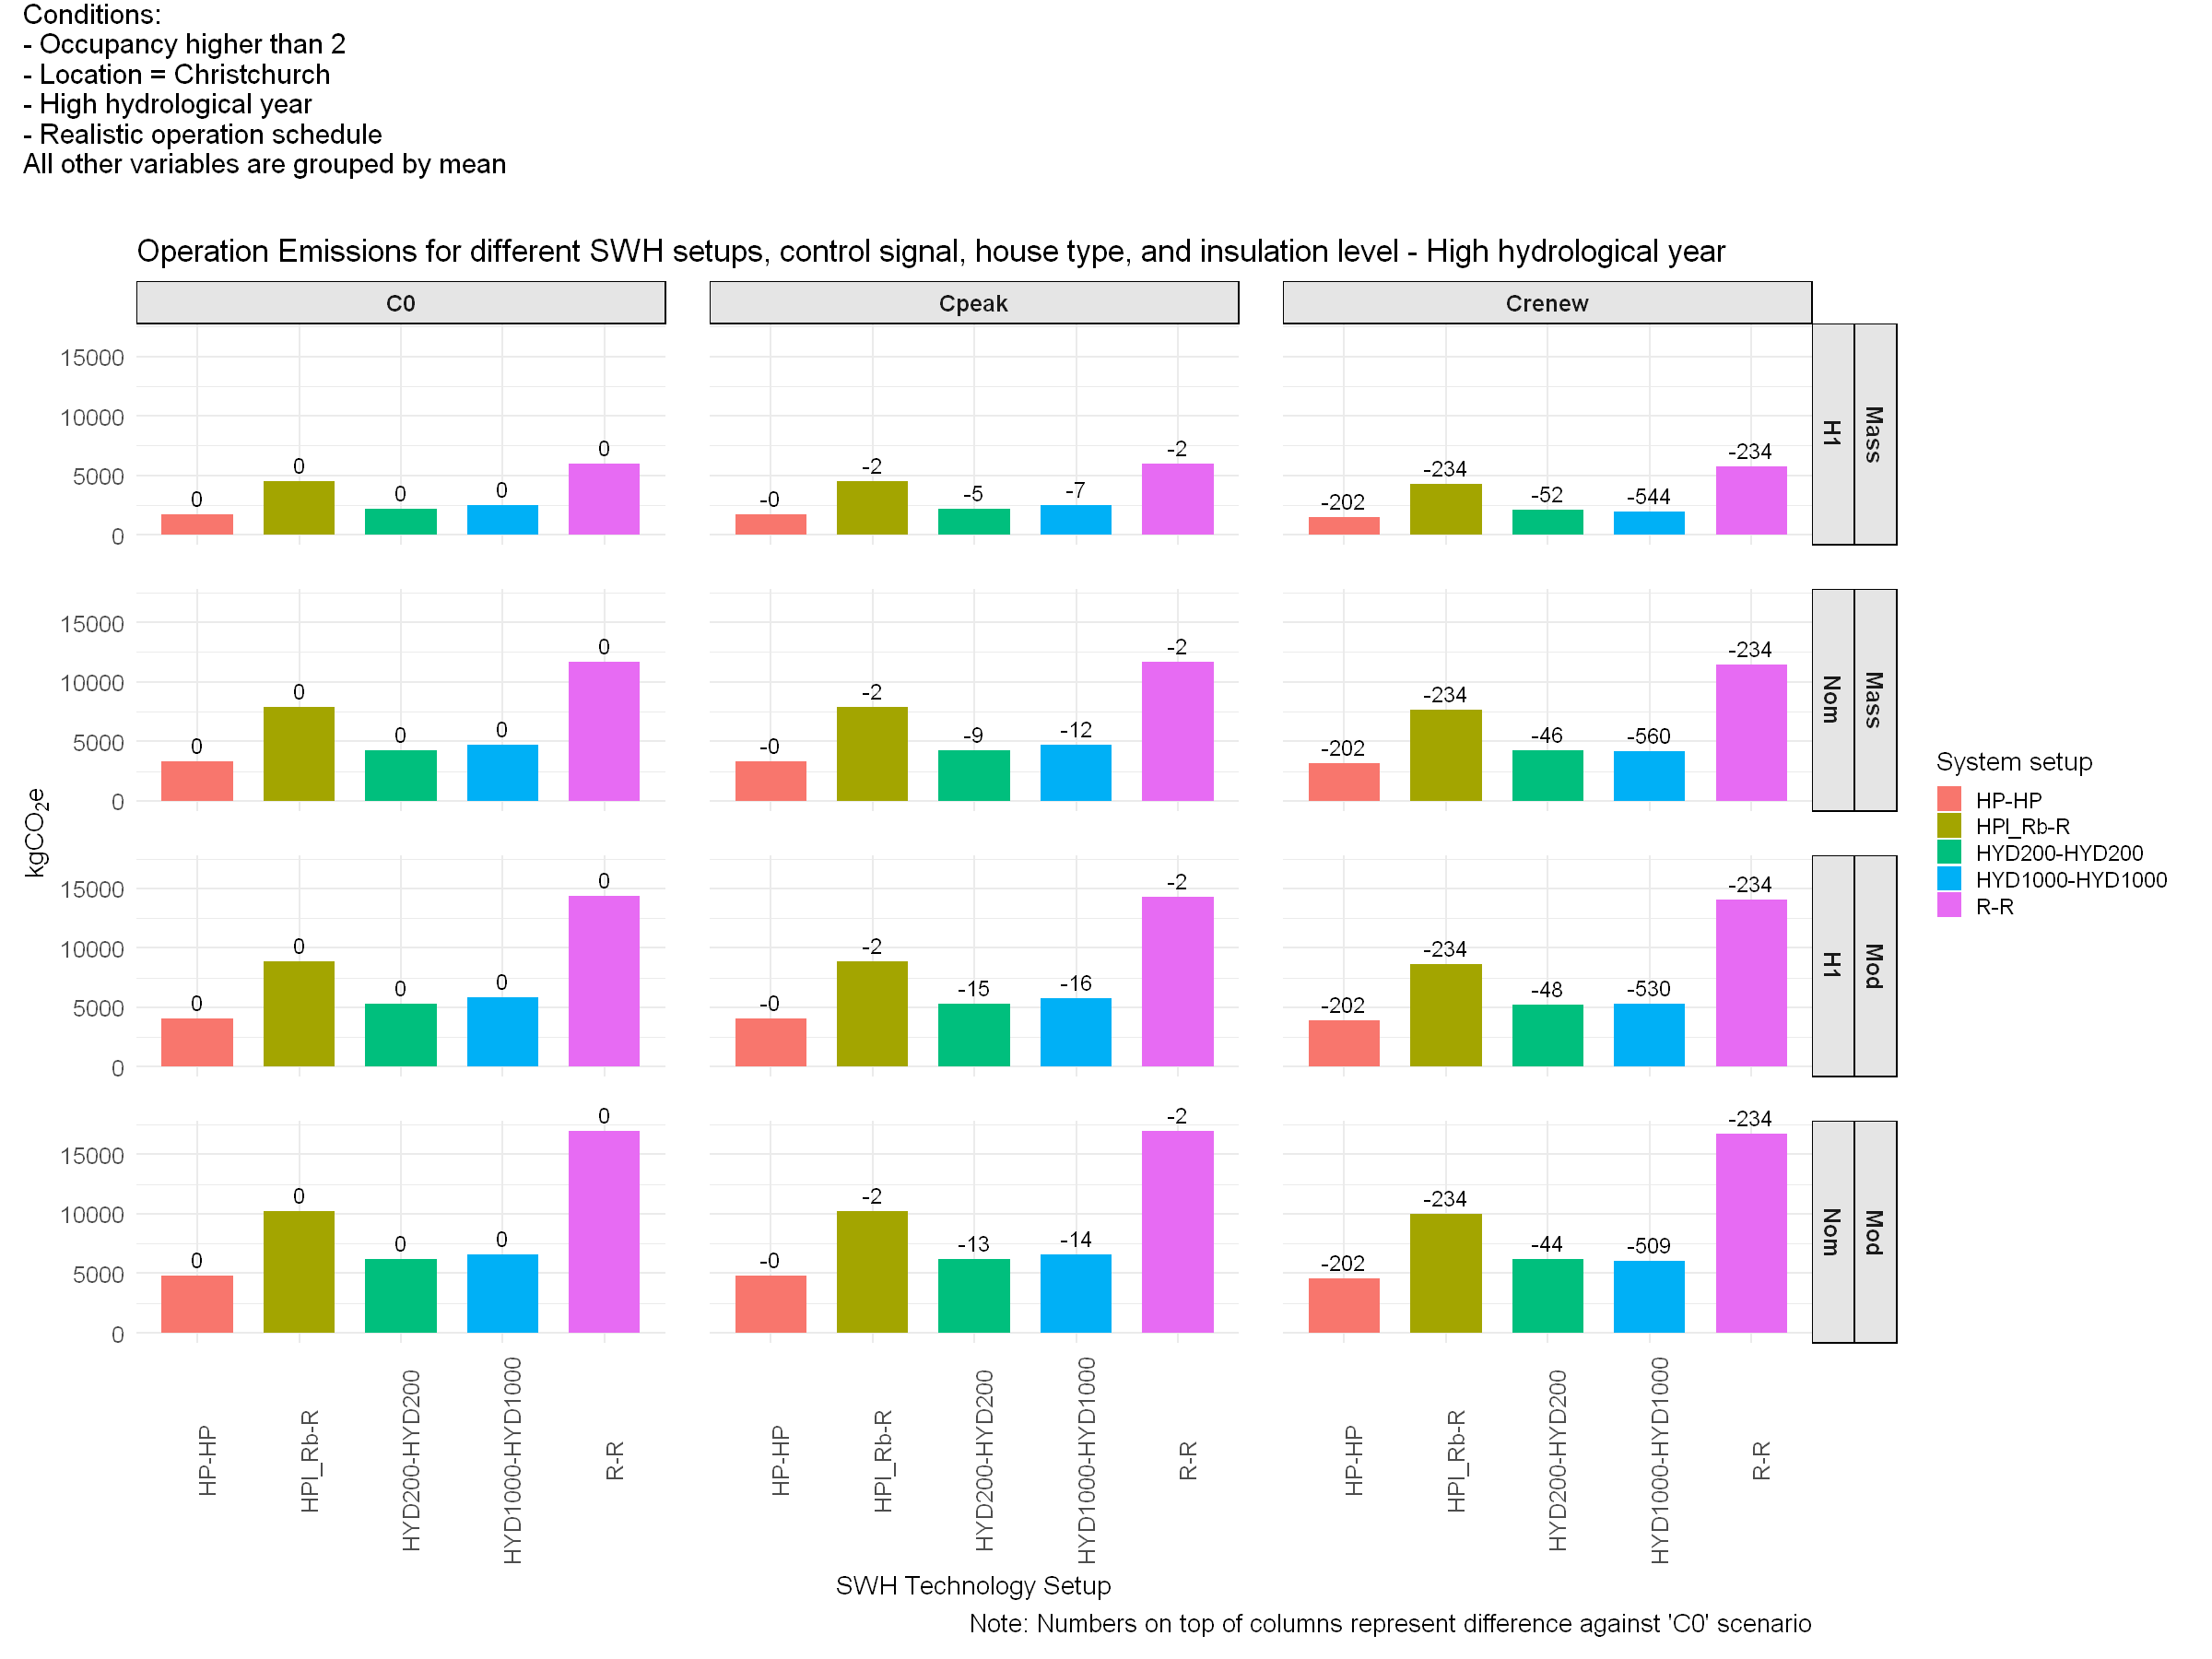

In [9]:
# Plot
options(repr.plot.width=20, repr.plot.height=15)
CS_plot_emission_high <- plot_CS_diff_high %>% filter(Type == 'Operation') %>%
  ggplot(aes(x = SH_DW_code, y = Emissions, fill=SH_DW_code)) +
  geom_col(width = 0.7) +
  geom_text(
    aes(label = sprintf("%.0f", diff_base)),
    vjust = -0.5, 
    size = 5,
    color = "black"
  ) +
  facet_grid(house_type + insulation ~ CS_code) +
    coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.margin = margin(t = 30, r = 10, b = 10, l = 10),
    plot.caption = element_text(size = 16)
  ) +
    labs(caption = "Note: Numbers on top of columns represent difference against 'C0' scenario",
        x = "SWH Technology Setup",
        y = expression(kgCO[2]*e),
        title = "Operation Emissions for different SWH setups, control signal, house type, and insulation level - High hydrological year",
        fill = 'System setup')

CS_plot_emission_high + 
  plot_annotation(
    title = "Conditions:\n- Occupancy higher than 2\n- Location = Christchurch\n- High hydrological year\n- Realistic operation schedule\nAll other variables are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

In [10]:
household_lifetime_Call_CS_low <- household_lifetime_Call %>% 
filter(Occ_code > 2, 
       Loc_code == 'CH',
      SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000'),
      Hydro_resource == 'Hlow',
      schedule == 'Real') %>%
group_by(house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_CS_low <- household_lifetime_Call_CS_low %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")
# Calculate base case emissions
base_CS_low <- plot_CS_low %>%
  filter(CS_code == 'C0') %>%
  select(house_type, insulation, SH_DW_code, Type, base_Emissions = Emissions)
# Join base emissions onto all CS_code values
plot_CS_diff_low <- plot_CS_low %>%
  left_join(base_CS_low, by = c("house_type", "insulation", "SH_DW_code", "Type")) %>%
  mutate(diff_base = Emissions - base_Emissions)

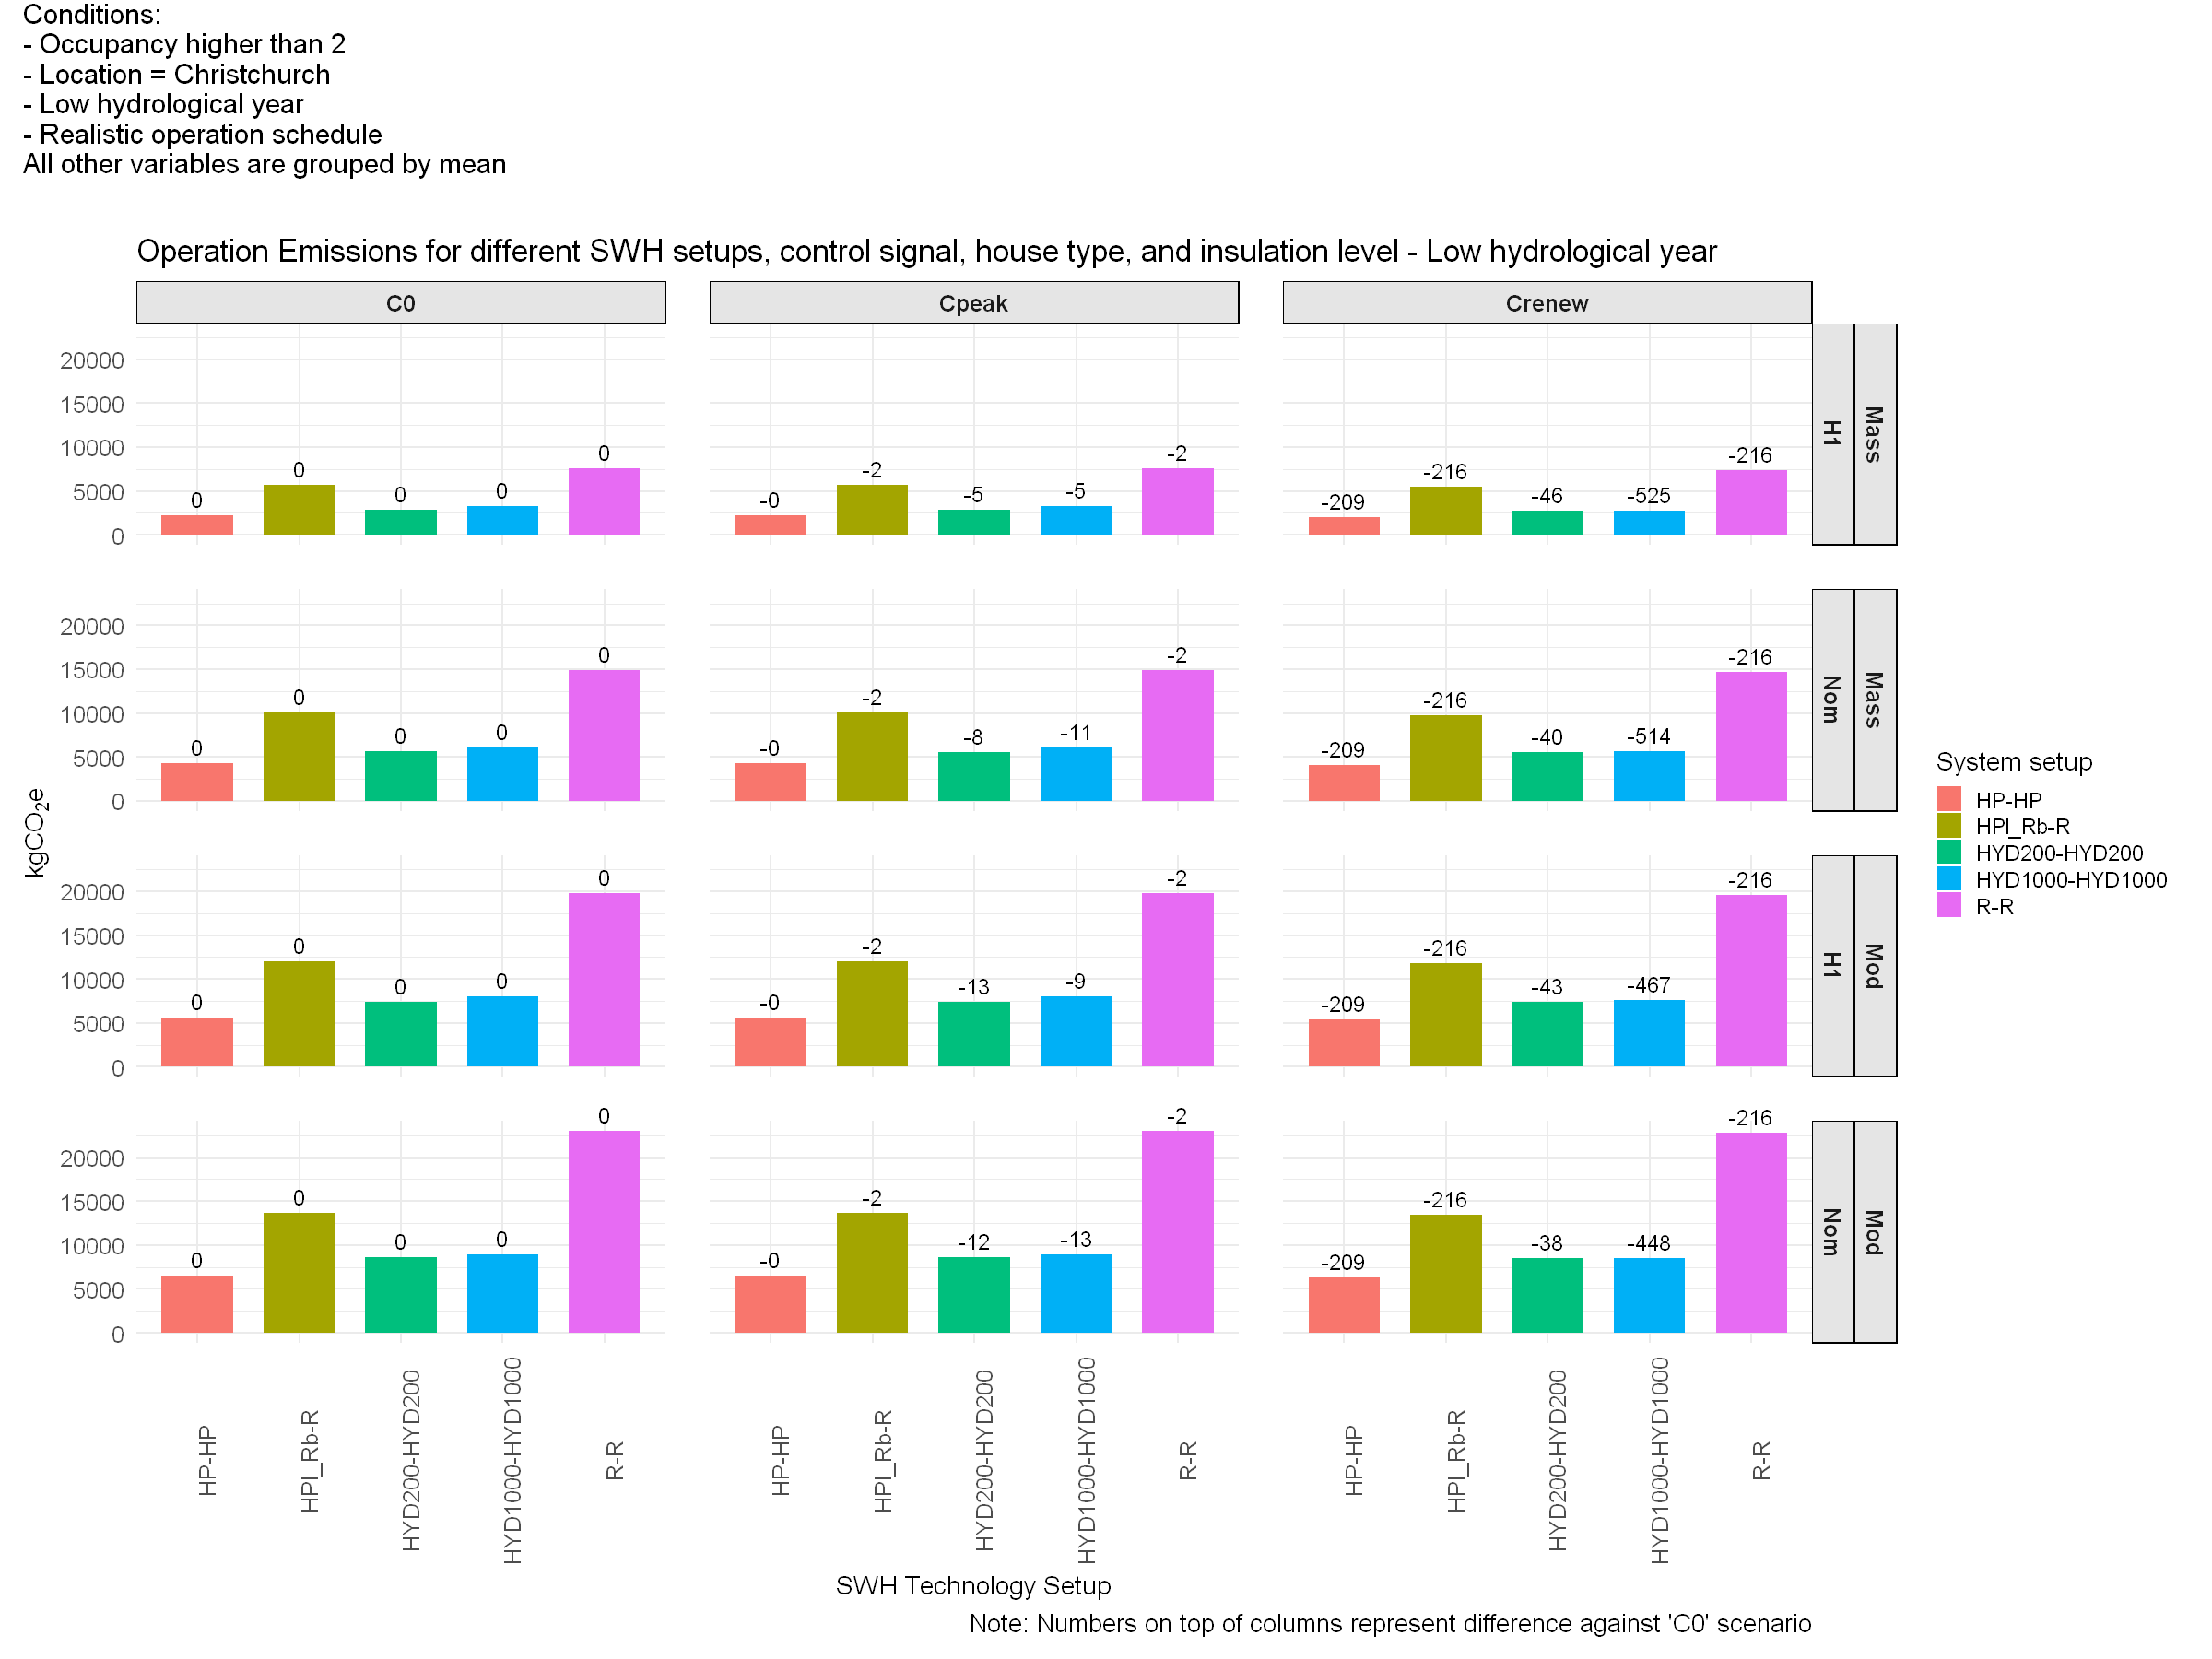

In [11]:
# Plot
options(repr.plot.width=20, repr.plot.height=15)
CS_plot_emission_low <- plot_CS_diff_low %>% filter(Type == 'Operation') %>%
  ggplot(aes(x = SH_DW_code, y = Emissions, fill = SH_DW_code)) +
  geom_col(width = 0.7) +
  geom_text(
    aes(label = sprintf("%.0f", diff_base)),
    vjust = -0.5, 
    size = 5,
    color = "black"
  ) +
  facet_grid(house_type + insulation ~ CS_code) +
    coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.margin = margin(t = 30, r = 10, b = 10, l = 10),
    plot.caption = element_text(size = 16)
  ) +
    labs(caption = "Note: Numbers on top of columns represent difference against 'C0' scenario",
        x = "SWH Technology Setup",
        y = expression(kgCO[2]*e),
        title = "Operation Emissions for different SWH setups, control signal, house type, and insulation level - Low hydrological year",
        fill = 'System setup')

CS_plot_emission_low + 
  plot_annotation(
    title = "Conditions:\n- Occupancy higher than 2\n- Location = Christchurch\n- Low hydrological year\n- Realistic operation schedule\nAll other variables are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
The plot above displays only operational emissions; embodied (not displayed) emissions remain constant across all control signal scenarios. The values shown above each column represent the difference in emissions relative to the 'C0' (no control) scenario. 
- The base ('C0') and peak shaving ('Cpeak') scenarios produce nearly identical results, with differences of less than 16 kg in lifetime operational emissions. In contrast, more significant reductions are observed in the renewable intermittent following ('Crenew') scenarios.
- Scenarios relying solely on heat pump technology exhibit higher embodied emissions. However, their substantially lower operational emissions result in the lowest overall life cycle emissions, making them the most appealing options from an environmental perspective.
- As expected, the plot for high hydrological years shows the highest potential in terms of emissions reduction.
- Emission reductions for setups that have resistive water heating show the same reductions across all house types and insulation level combinations. Resistive water heating was modelled as a function of occupancy only. 
### A closer look to hydronic setups
We isolate hydronic setups and explore the impact of thermal storage size on the operational emissions. Potentially, these systems could adopt an intermittent following control signal that can allow them to operate at times of high solar PV and wind power output, hence allowing them to reduce the operational emissions. Furthermore, we explore the impact of occupancy on the operation of these setups.

In [66]:
technology_lifetime_Call <- read_csv("https://raw.githubusercontent.com/pxgo17/EECA_SWH_LCA/refs/heads/main/data/processed/lca/technology_lifetime_Call.csv") %>%
    suppressMessages()
# Step 1: Filter and aggregate
technology_lifetime_Call_hyd <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HYD200", "HYD500", "HYD1000")) %>%  
  filter(CS_code != 'Cpeak') %>%
  filter(Hydro_resource == 'Hhigh') %>%
  filter(Loc_code == 'CH') %>%
  filter(house_type == 'Mass', insulation == 'H1', schedule == 'Real') %>%
  mutate(DW_code = factor(DW_code, levels = c("HYD200", "HYD500", "HYD1000"))) %>%
  group_by(DW_code, Loc_code, Occ_code, HP_cap, `Tank_Volume (L)`, CS_code) %>% 
  summarise(
    kgCO2 = mean(kgCO2_oper_life),
    kWh = mean(P_annual_kWh_life),
    .groups = "drop"
  ) %>%
  mutate(kgCO2_per_kWh = kgCO2 / kWh)

# Step 2: Compute base case (CS_code == "C0") per DW_code
technology_lifetime_Call_hyd_base <- technology_lifetime_Call_hyd %>%
  filter(CS_code == "C0") %>%
  select(DW_code, Loc_code, Occ_code, HP_cap, `Tank_Volume (L)`, kgCO2_base = kgCO2)

# Step 3: Join and calculate differences
technology_lifetime_Call_hyd_diff <- technology_lifetime_Call_hyd %>%
  left_join(
    technology_lifetime_Call_hyd_base,
    by = c("DW_code", "Loc_code", "Occ_code", "HP_cap", "Tank_Volume (L)")
  ) %>%
  mutate(
    diff = (kgCO2 - kgCO2_base) / kgCO2_base * 100 # percent difference from base case
  )

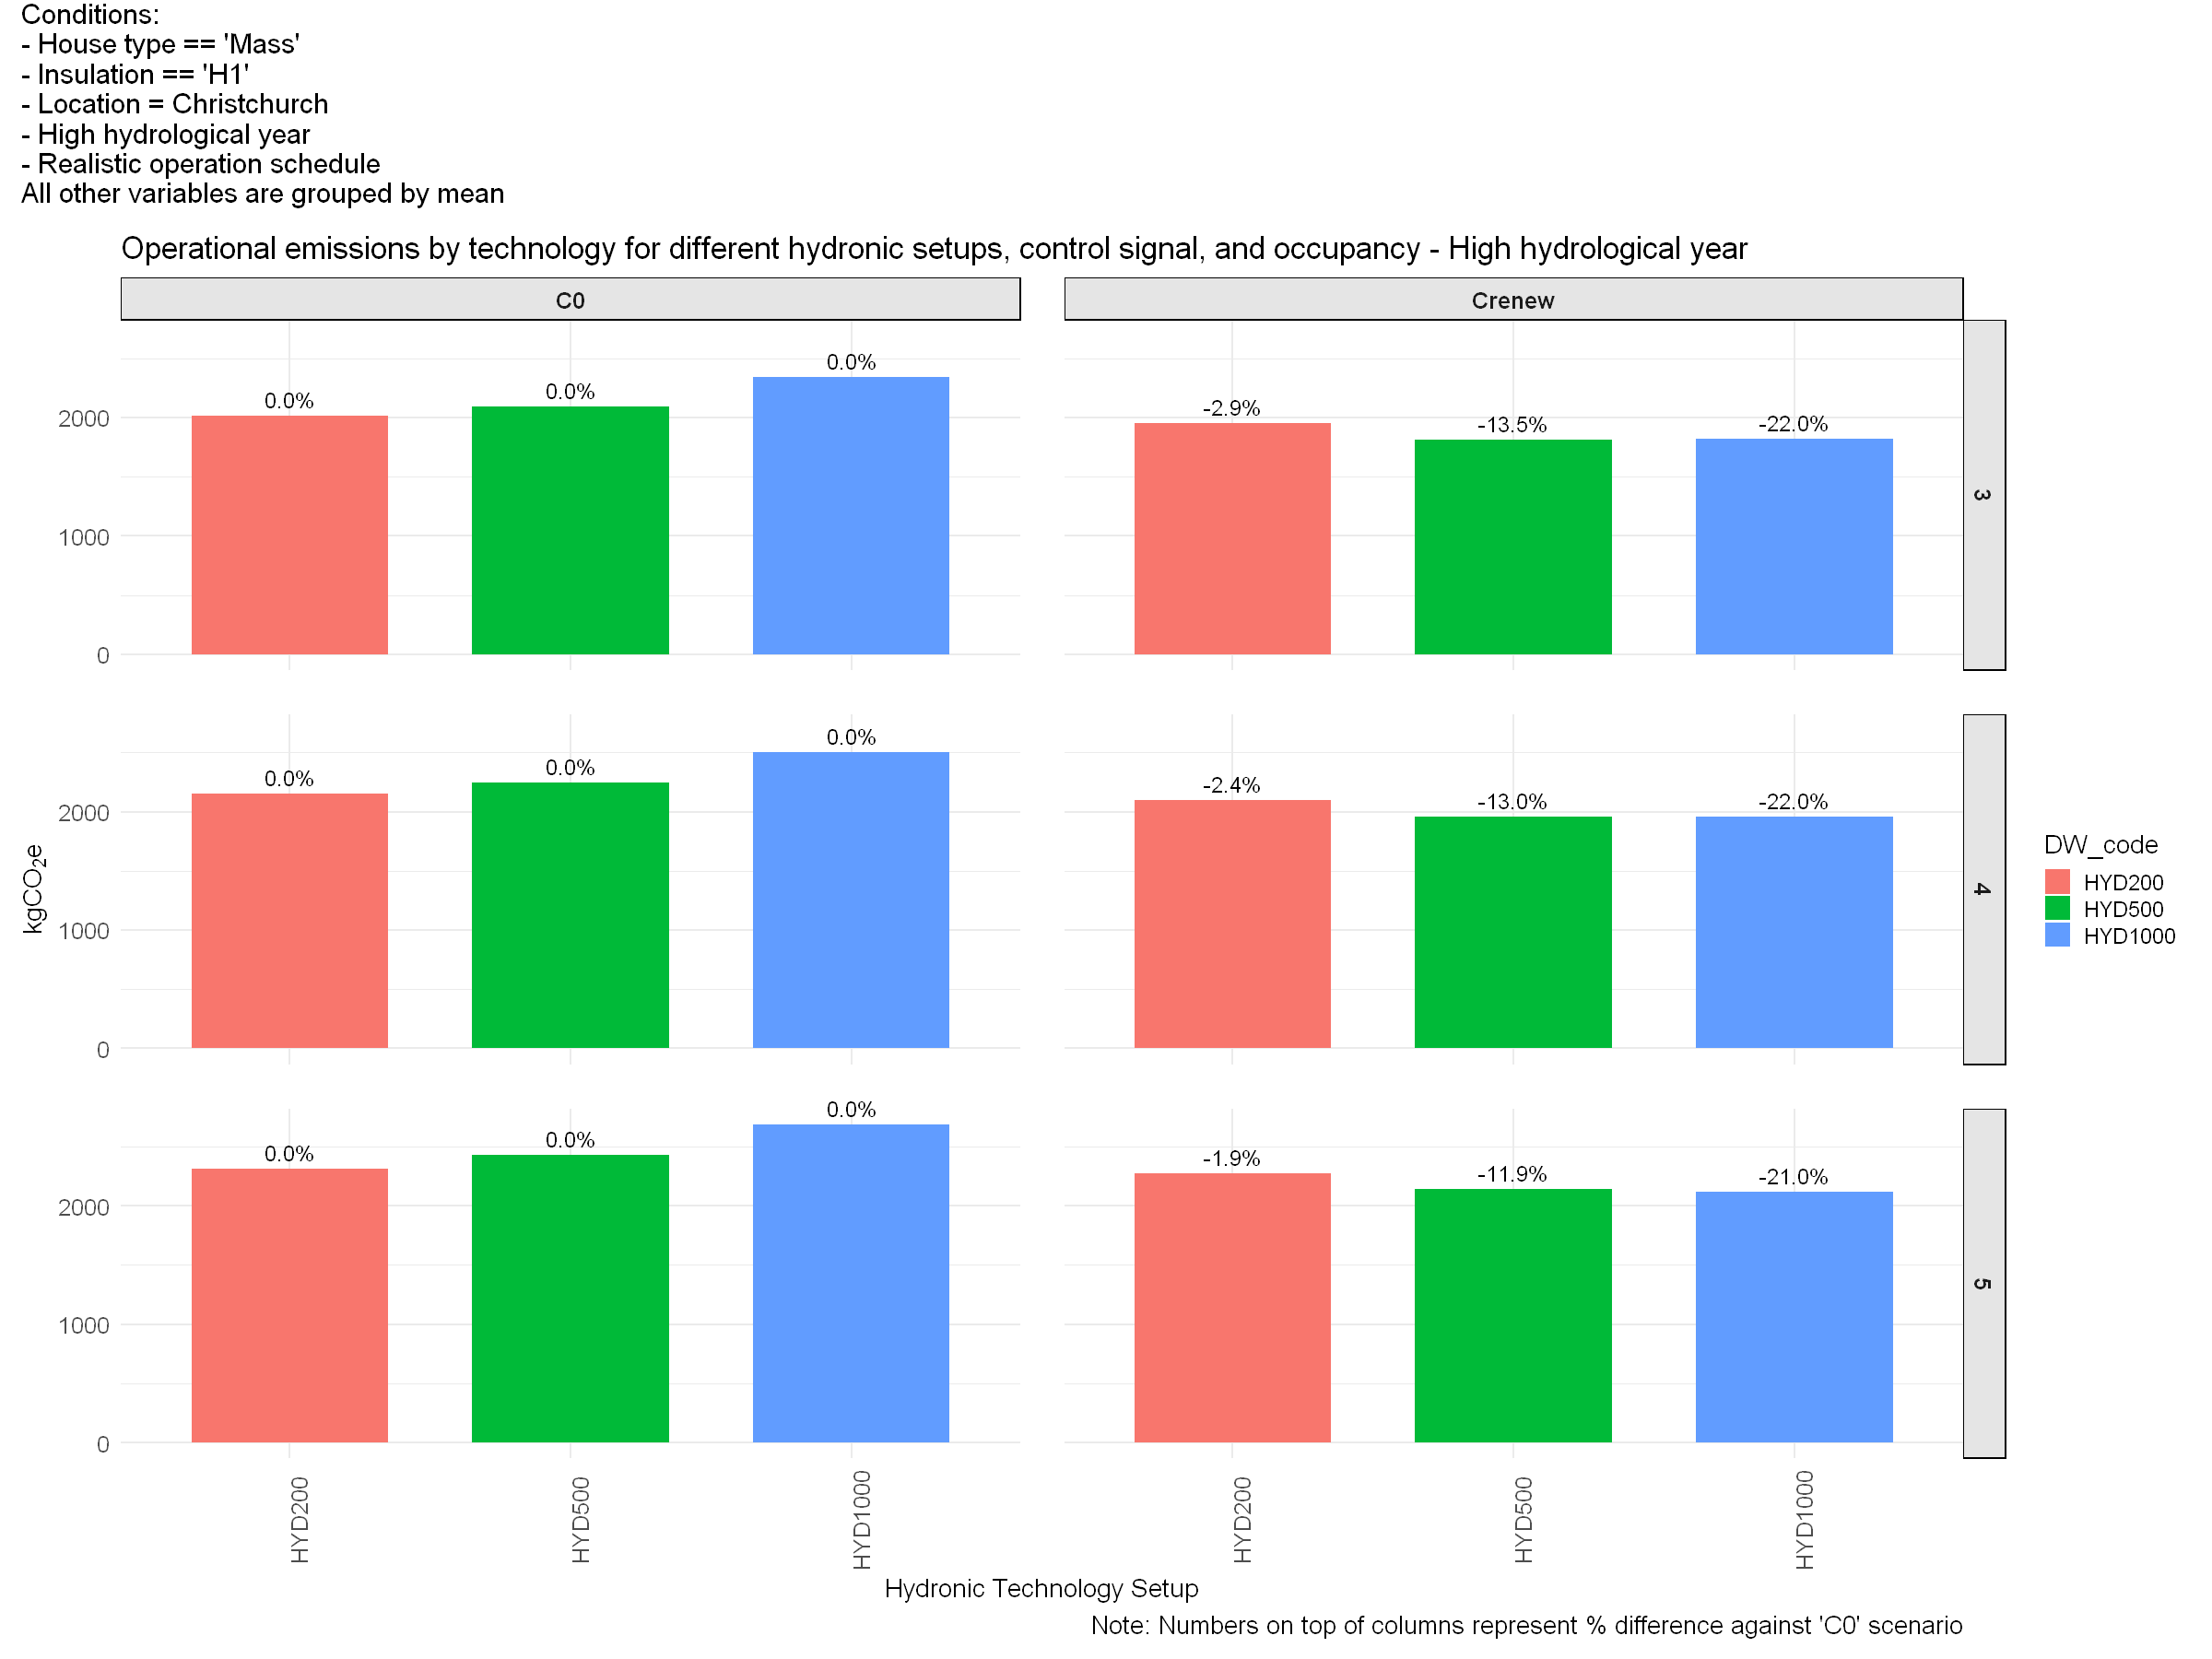

In [13]:
hyd_plot <- technology_lifetime_Call_hyd_diff %>%
  ggplot(aes(x = DW_code, y = kgCO2, fill = DW_code)) + 
  geom_col(width = 0.7) +
  geom_text(
    aes(label = ifelse(!is.na(diff), sprintf("%.1f%%", diff), "")),
    vjust = -0.5, 
    size = 5,
    color = "black"
  ) +
  facet_grid(Occ_code ~ CS_code) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size = 15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.caption = element_text(size = 16)
  ) +
  labs(
    x = "Hydronic Technology Setup",
    y = expression(kgCO[2]*e),
    title = "Operational emissions by technology for different hydronic setups, control signal, and occupancy - High hydrological year",
    caption = "Note: Numbers on top of columns represent % difference against 'C0' scenario",
  )

hyd_plot + 
  plot_annotation(
    title = "Conditions:\n- House type == 'Mass'\n- Insulation == 'H1'\n- Location = Christchurch\n- High hydrological year\n- Realistic operation schedule\nAll other variables are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

Interestingly, the plot above shows that, for the specified settings, increasing thermal storage can reduce operational emissions if system controls allow operation during periods of high intermittent power generation. The plot also shows that potential reductions decrease as occupancy increases, which is expected since higher occupancy limits the flexibility to operate within specific time windows.
The difference in potential reduction between 200 L and 500 L of storage is greater than that between 500 L and 1000 L, suggesting that the benefits plateau beyond a certain storage size.
#### How does the ability to use thermal storage for load shifting affect the overall attractiveness of hydronic scenarios?
More thermal storage increases flexibility for demand shifting, but it also raises the embodied emissions of the system. To assess the net attractiveness of the three hydronic setups, we can compare both operational and embodied emissions to determine whether the reduction potential of intermittent-following hydronic setups makes them more appealing than:
- the all heat pump setups (so far the most favourable in terms of emissions), and
- the hybrid setup (HPl_Rb-R), which likely represents business-as-usual (BAU).

In [14]:
household_lifetime_Call_CS_high <- household_lifetime_Call %>% 
filter(Occ_code == 3, 
       Loc_code == 'CH',
      SH_DW_code %in% c('HP-HP', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD500-HYD500', 'HYD1000-HYD1000'),
      Hydro_resource == 'Hhigh',
      schedule == 'Real') %>%
group_by(house_type, insulation, SH_DW_code, CS_code) %>%
  summarise(Embodied = mean(Embodied_life),
            Operation = mean(Operation_life), .groups = 'drop') %>% ungroup() %>%
  mutate(Total = Embodied + Operation)
# Reshape data to long format for ggplot2
plot_CS_high <- household_lifetime_Call_CS_high %>%
  pivot_longer(cols = c(Embodied, Operation), names_to = "Type", values_to = "Emissions")

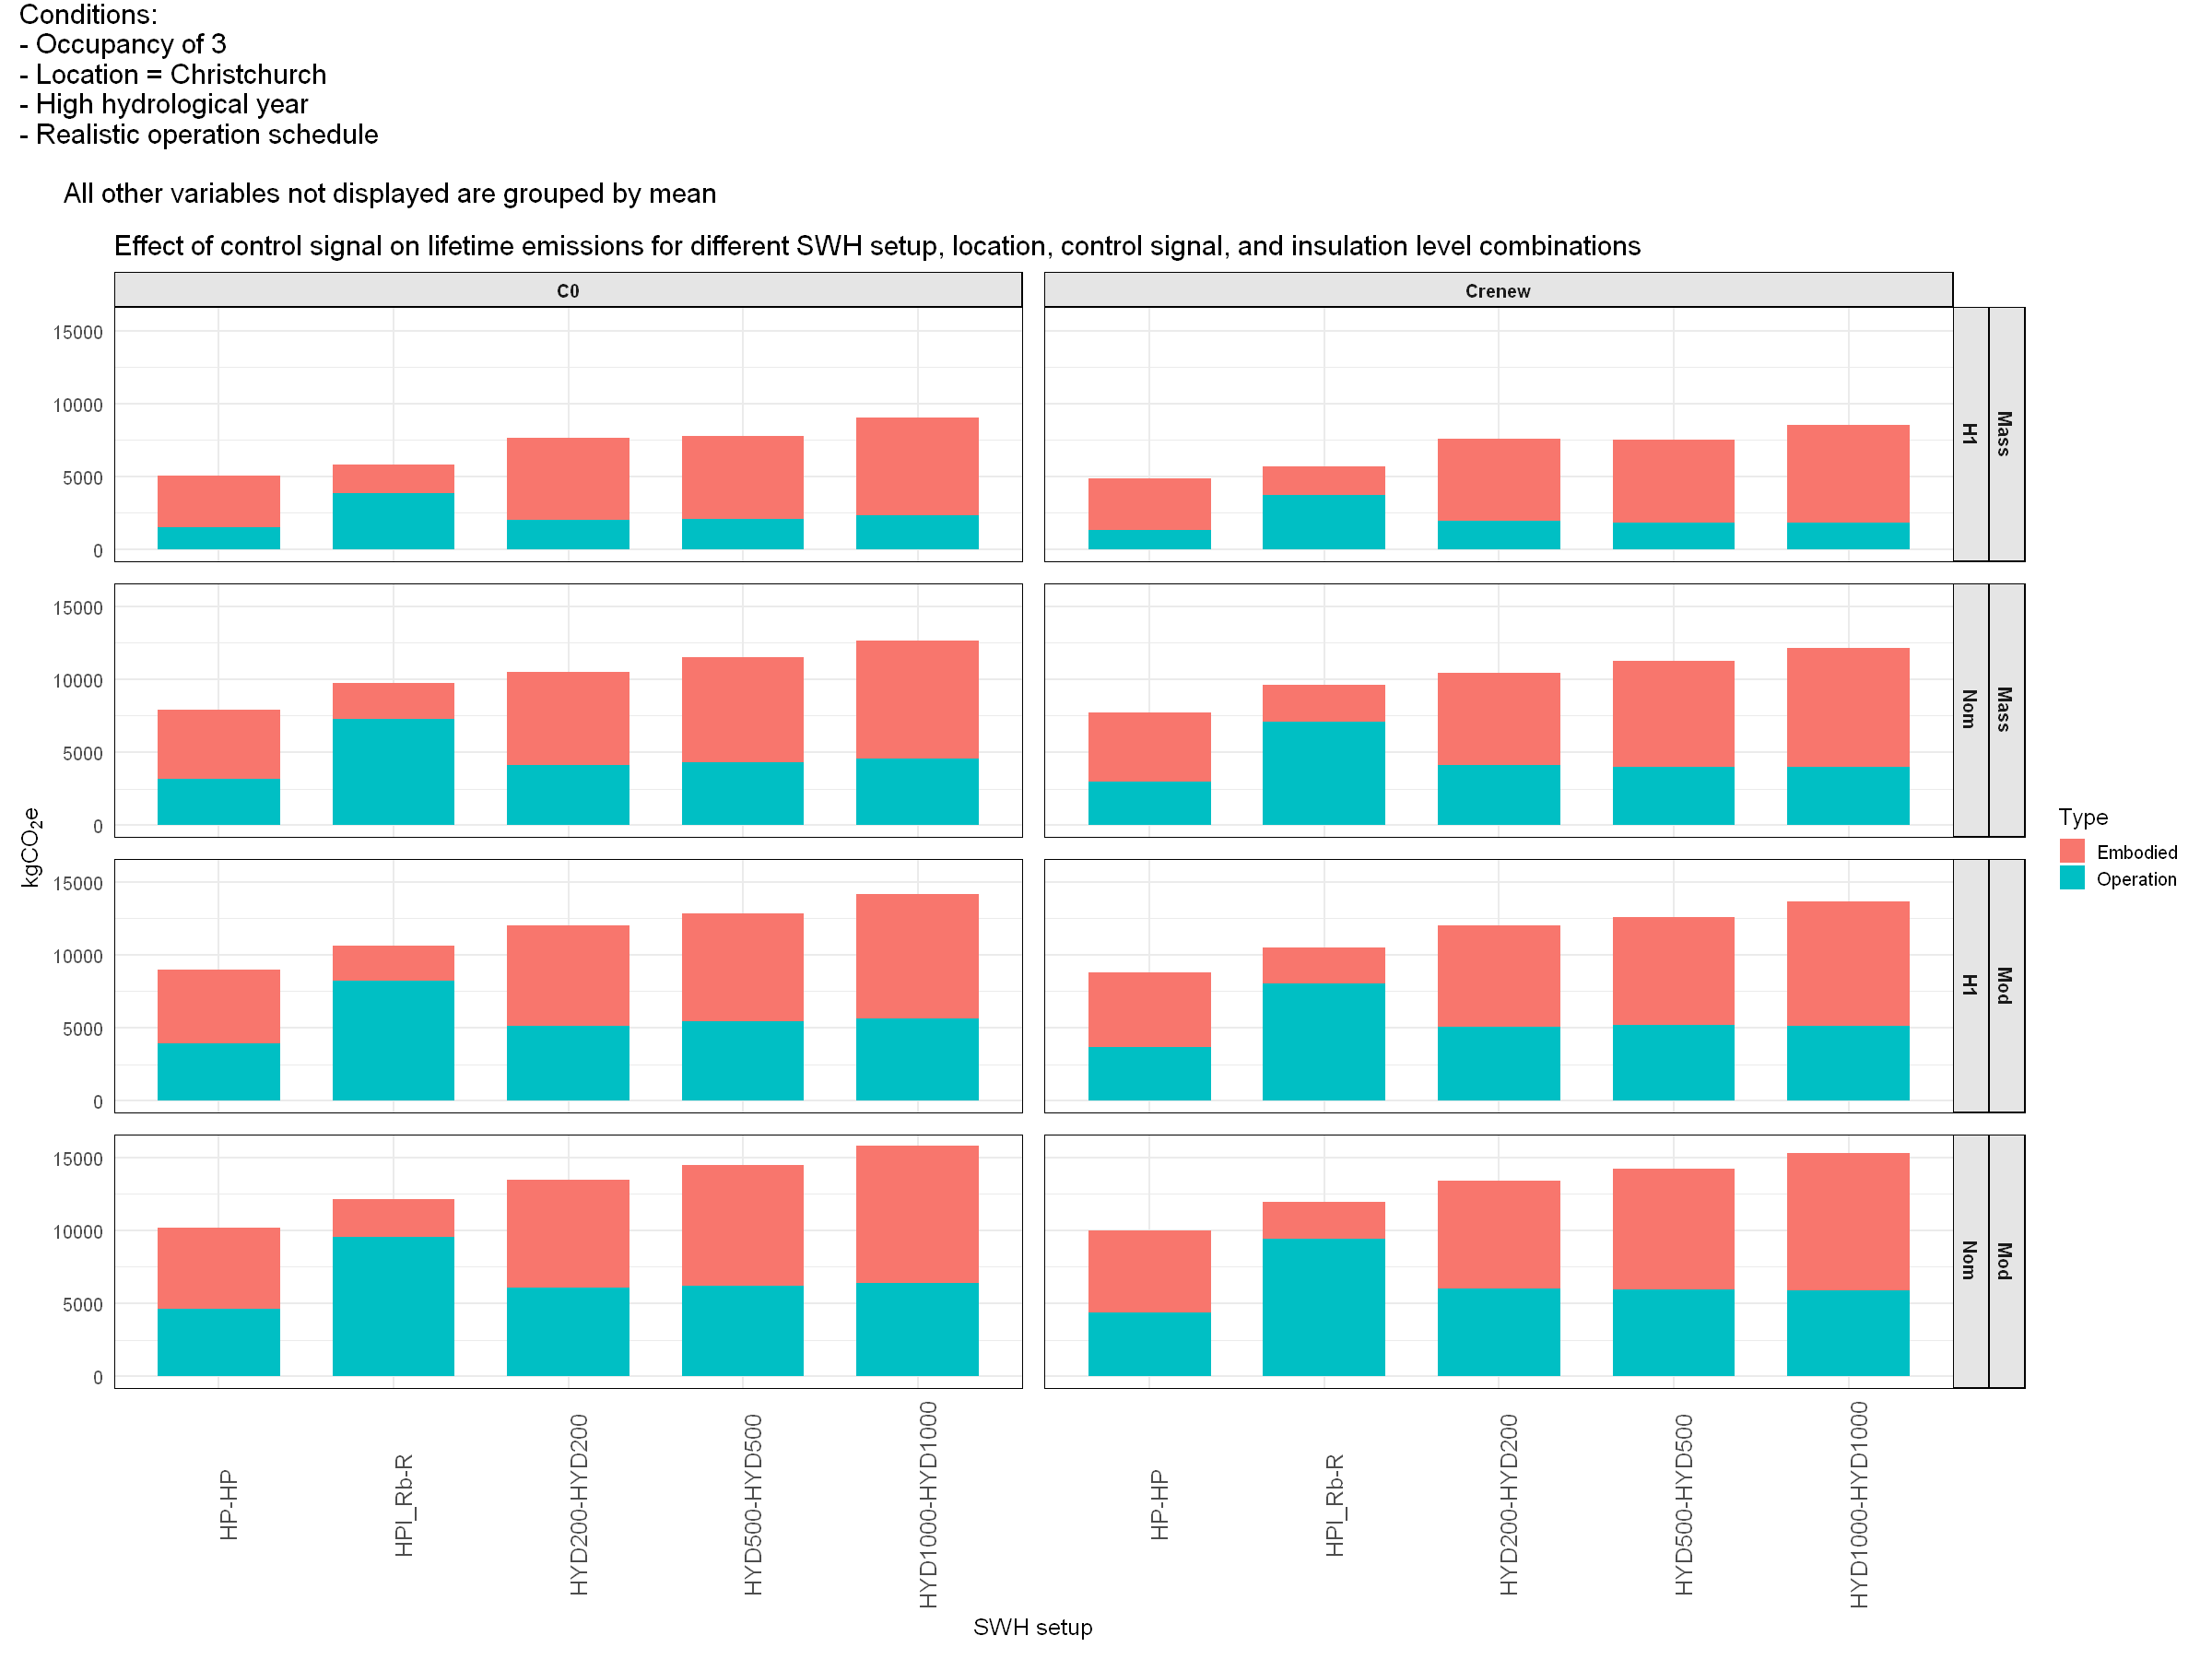

In [15]:
options(repr.plot.width=20, repr.plot.height=15)
CS_attractiveness_plot <- plot_CS_high %>%
  filter(CS_code != 'Cpeak') %>%
  ggplot(aes(x = SH_DW_code, y = Emissions, fill = Type)) +
  geom_col(position = "stack", width = 0.7) +
  facet_grid(house_type + insulation ~ CS_code) +
  theme_minimal(base_size = 15) +
  labs(x = "SWH setup",
       y = expression(kgCO[2]*e),
       title = "Effect of control signal on lifetime emissions for different SWH setup, location, control signal, and insulation level combinations") +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    strip.text = element_text(face = "bold"),
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.border = element_rect(color = "black", fill = NA, size = 0.1),
    panel.spacing = unit(1, "lines")
  )

CS_attractiveness_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy of 3\n- Location = Christchurch\n- High hydrological year\n- Realistic operation schedule\n
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
The plot above displays both embedded and operational emissions for a few cases. In terms of total lifetime emissions, it can be seen that both the all-heat pump (HP-HP) and BAU (HPl_Rb-R) outperform the hydronic setups even for the 'intermittent-following' signal cases. 
For hydronic cases, the reduction in operational emissions achieved through greater thermal storage is not enough to offset the resulting increase in embodied emissions.
## Impact of oversizing water heating storage in non-hydronic settings
In non-hydronic settings, thermal storage only provides load-shifting flexibility for water heating demand. This part looks at the potential benefits for these cases, particularly for systems running with a heat pump. 

In [37]:
technology_lifetime_Call_DW <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HP", "HPo")) %>%  
  filter(CS_code != 'Cpeak') %>%
  filter(Hydro_resource == 'Hhigh') %>%
  filter(Loc_code == 'CH') %>%  
  group_by(DW_code, Loc_code, Occ_code, HP_cap,`Tank_Volume (L)`, CS_code) %>% 
  summarise(kgCO2 = mean(kgCO2_oper_life),
            kWh = mean(P_annual_kWh_life)) %>% 
  suppressMessages() %>%
  ungroup() %>%
  mutate(kgCO2_per_kWh = kgCO2/kWh) 
# Calculate base case emissions
technology_lifetime_Call_DW_base <- technology_lifetime_Call_DW %>%
  filter(CS_code == 'C0') %>%
  select(Loc_code, DW_code, Occ_code, HP_cap, `Tank_Volume (L)`, kgCO2_C0 = kgCO2)
# Join base emissions onto all CS_code values
technology_lifetime_Call_DW_diff <- technology_lifetime_Call_DW %>%
  left_join(technology_lifetime_Call_DW_base, by = c("Loc_code", "DW_code", "Occ_code", "HP_cap", "Tank_Volume (L)")) %>%
  mutate(diff = 100*(kgCO2 - kgCO2_C0)/kgCO2)

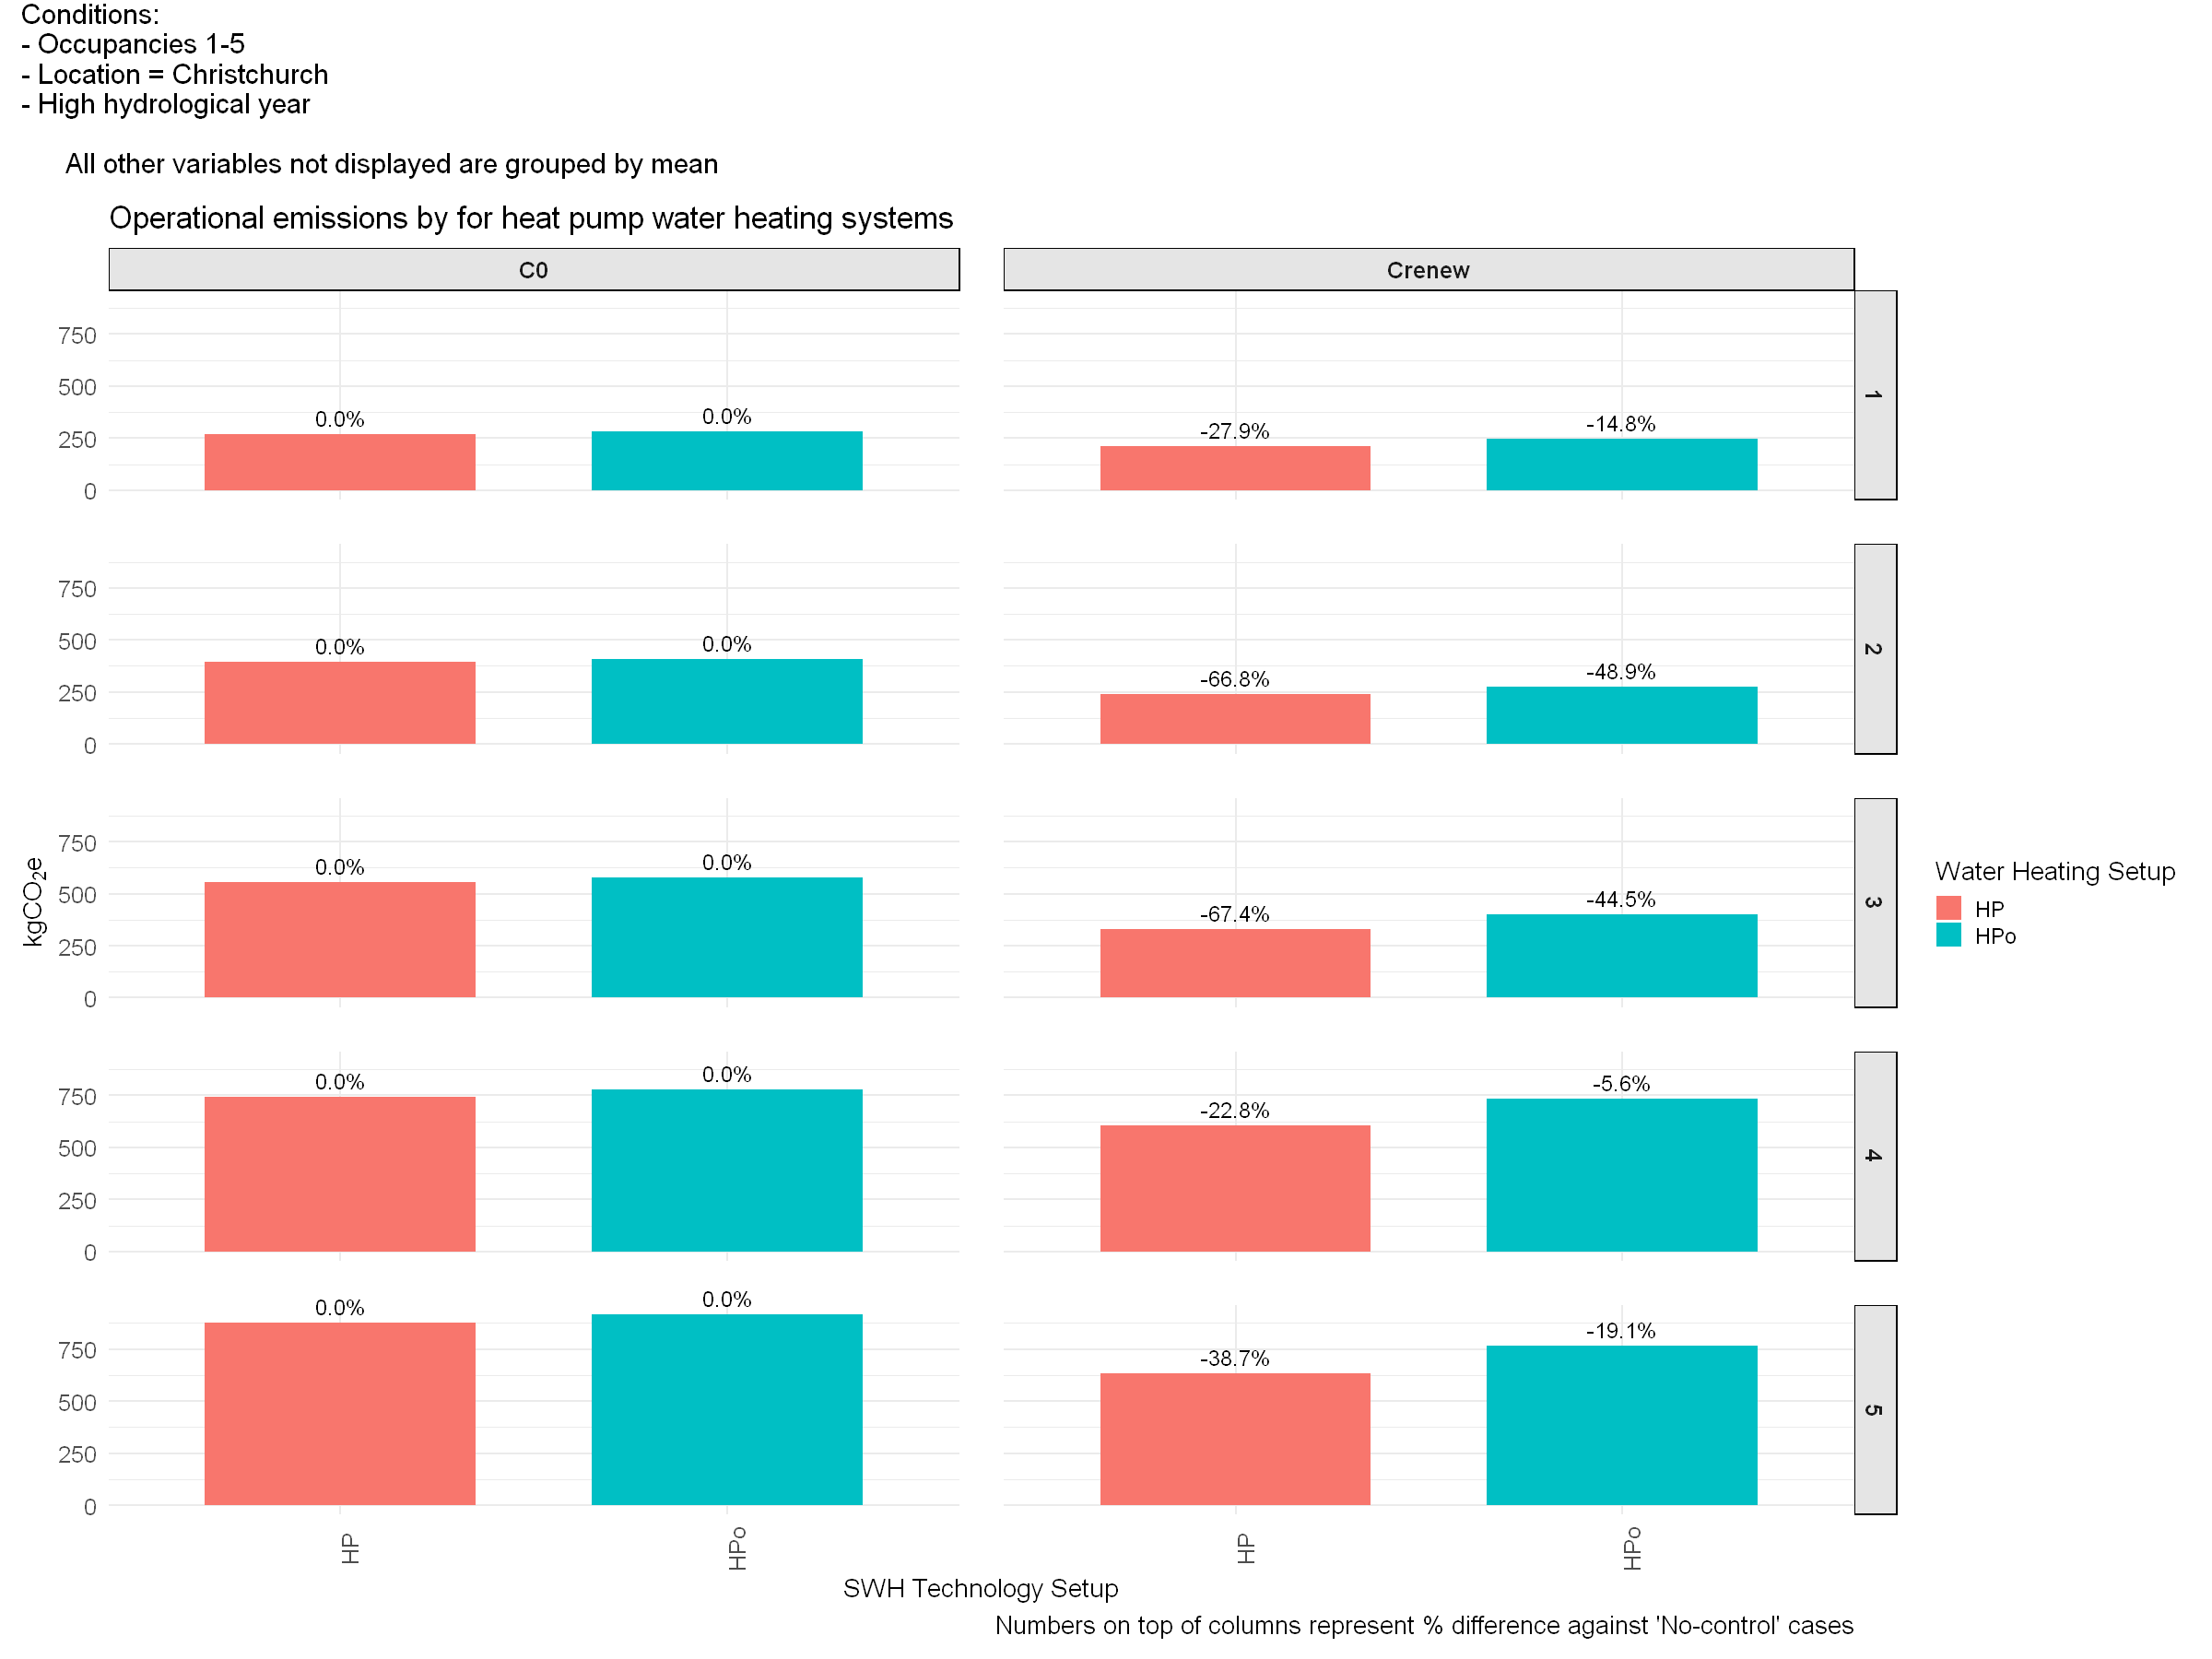

In [52]:
oversize_plot <- technology_lifetime_Call_DW_diff %>%    
  ggplot(aes(x = DW_code, y = kgCO2, fill=DW_code)) + 
  geom_col(width = 0.7) +
  geom_text(
    aes(label = ifelse(!is.na(diff), sprintf("%.1f%%", diff), "")),
    vjust = -0.5, 
    size = 5,
    color = "black"
  ) +
  facet_grid(Occ_code ~ CS_code) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.caption = element_text(size = 16)
  ) +
  labs(x = "SWH Technology Setup",
       y = expression(kgCO[2]*e),
       title = "Operational emissions by for heat pump water heating systems",
       fill= "Water Heating Setup",
       caption = "Numbers on top of columns represent % difference against 'No-control' cases")

oversize_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancies 1-5\n- Location = Christchurch\n- High hydrological year\n
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
The plot above shows operational emissions for water heating with heat pumps, including cases with oversized storage tanks ('HPo').
As expected, operational emissions are higher when no control signal is applied and for scenarios with higher occupancy. There is a high potential for emission reduction in houses with 2 or 3 occupants. Unlike in the hydronic cases, increasing tank size does not yield additional emission reductions compared to the nominal size—in fact, it leads to higher emissions. This is because the added volume of water increases heating demand, while the size increase is still insufficient to provide meaningful operational flexibility. As a result, heat pumps operate more frequently and consume more electricity.
Compared to hydronic settings, operational emissions for these systems are significantly lower, as they only run to meet water-heating demand.
## Impact of climate on heat pump performance
It is worth exploring this aspect, since heat pump water heaters in the model are defined with control signal, occupancy, tank size, and outside temperature (climate) as independent variables. Additionally, the water-heating demand was assumed to be constant across all locations, house types, and insulation levels. Cases with a high hydrological year were isolated for analysis.

In [44]:
technology_lifetime_Call_DW_HP <- technology_lifetime_Call %>% 
  filter(!is.na(DW_code)) %>% 
  filter(DW_code %in% c("HP")) %>%  
  filter(Hydro_resource == 'Hhigh') %>% 
  filter(CS_code != 'Cpeak') %>%
  group_by(DW_code, Loc_code, Occ_code, HP_cap,`Tank_Volume (L)`, CS_code) %>% 
  summarise(kgCO2 = mean(kgCO2_oper_life),
            kWh = mean(P_annual_kWh_life)) %>% 
  suppressMessages() %>%
  ungroup() %>%
  mutate(kgCO2_per_kWh = kgCO2/kWh) 
# Calculate base case emissions
technology_lifetime_Call_DW_HP_base <- technology_lifetime_Call_DW_HP %>%
  filter(Loc_code == 'AK') %>%
  select(Occ_code, HP_cap, `Tank_Volume (L)`, kgCO2_AK = kgCO2, CS_code)
# Join base emissions onto all CS_code values
technology_lifetime_Call_DW_HP_diff <- technology_lifetime_Call_DW_HP %>%
  left_join(technology_lifetime_Call_DW_HP_base, by = c("Occ_code", "HP_cap", "Tank_Volume (L)","CS_code")) %>%
  mutate(diff = 100*(kgCO2 - kgCO2_AK)/kgCO2)

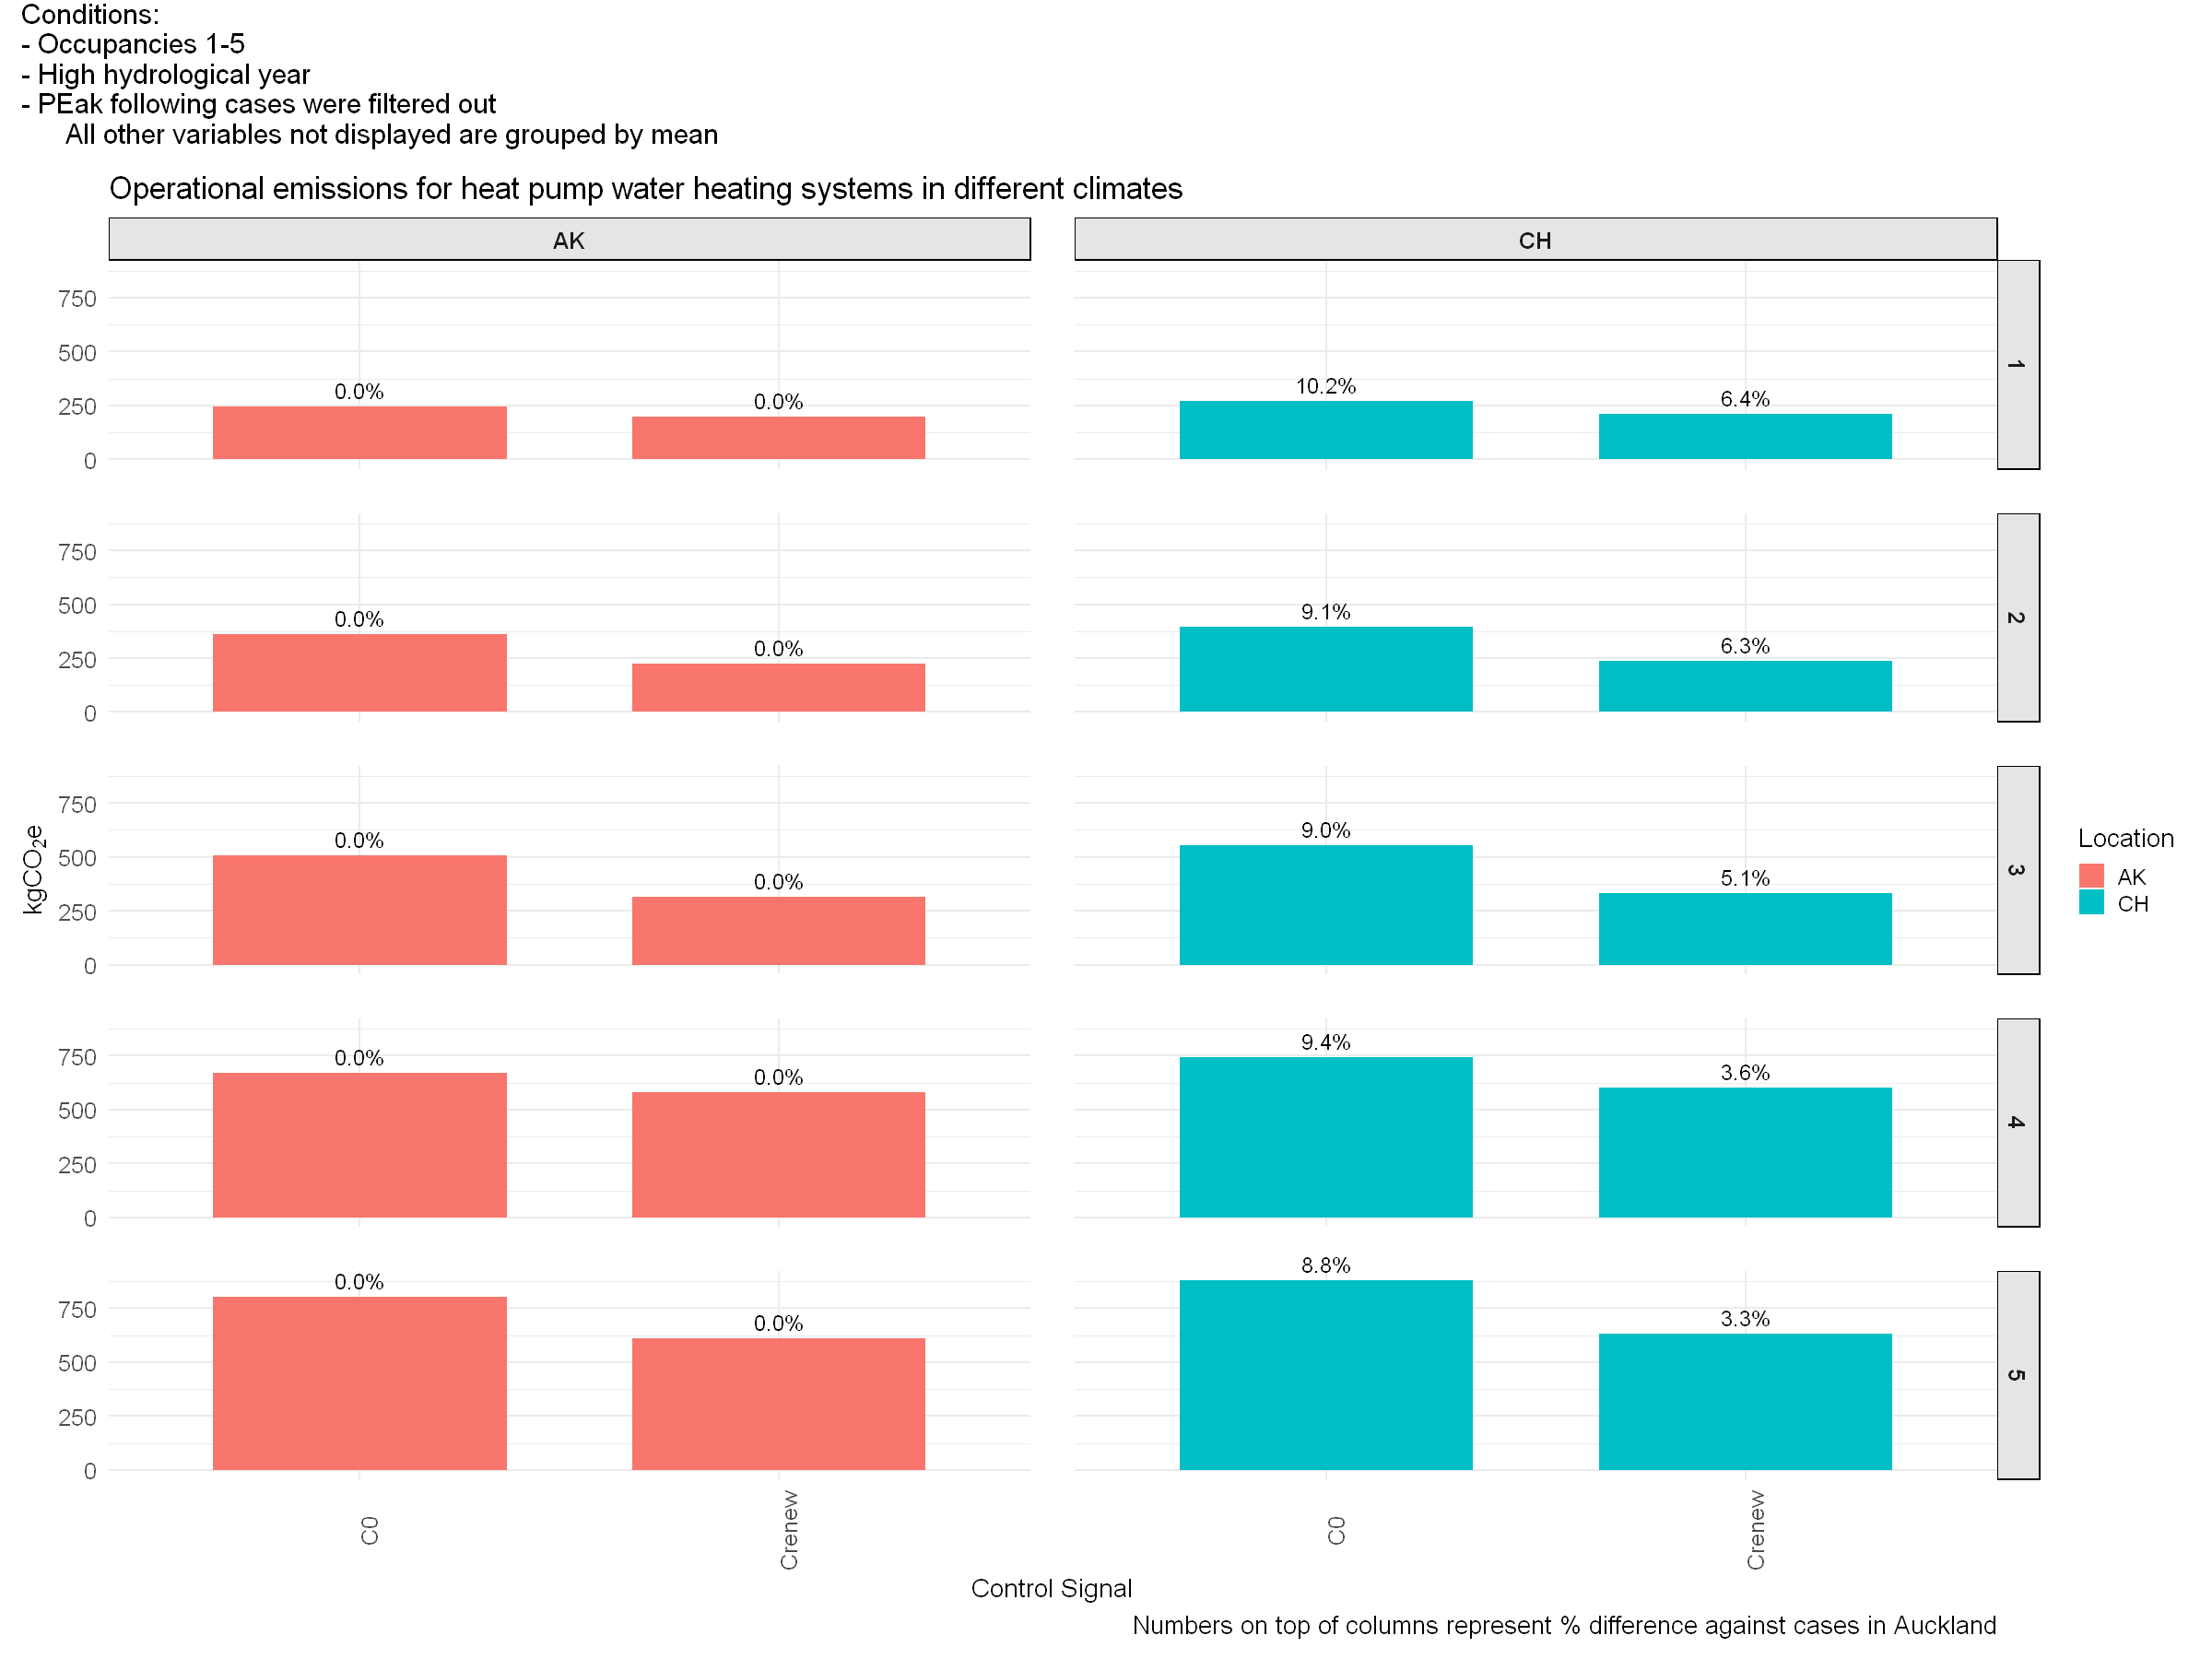

In [54]:
climate_plot <- technology_lifetime_Call_DW_HP_diff %>%    
  ggplot(aes(x = CS_code, y = kgCO2, fill = Loc_code)) + 
  geom_col(width = 0.7) +
  geom_text(
    aes(label = ifelse(!is.na(diff), sprintf("%.1f%%", diff), "")),
    vjust = -0.5, 
    size = 5,
    color = "black"
  ) +
  facet_grid(Occ_code ~ Loc_code) +
  coord_cartesian(clip = "off") +
  theme_minimal(base_size = 17) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.caption = element_text(size = 16)
  ) +
  labs(x = "Control Signal",
       y = expression(kgCO[2]*e),
       title = "Operational emissions for heat pump water heating systems in different climates",
       fill= "Location",
       caption = "Numbers on top of columns represent % difference against cases in Auckland")

climate_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancies 1-5\n- High hydrological year\n- PEak following cases were filtered out
      All other variables not displayed are grouped by mean",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

### Discussion
The plot above shows operational emissions for water heating with heat pumps across different locations (i.e., climate zones). The patterns are consistent with those observed in earlier plots: systems that align their operation with renewable generation have lower emissions, while emissions increase with the number of occupants.
Thermal demand is assumed to be identical for both locations. However, operational emissions are higher in Christchurch due to lower air temperatures—particularly during the night and early morning—which reduce the performance of air-source heat pumps. In the worst-case scenario (a single-occupant house in Christchurch with a no-control signal), emissions are up to 10.2% higher than in Auckland. The differences are more pronounced for no-control cases, indicating that the impact of climate can be mitigated through the implementation of appropriate control strategies.

## Indirect impacts of control signal
As shown above, the use of thermal storage can contribute to reducing operational emissions by enabling systems to operate during periods when the electricity emission factor is relatively low. In addition to emissions reductions, thermal storage offers a secondary benefit. It allows for load shifting to off-peak periods, improving the overall utilisation of the power system. By shifting demand away from peak times, thermal storage can help reduce peak loads, potentially lowering the required capacity for power generation, transmission, and distribution infrastructure.
In this section, we provide insights into the potential reduction in peak power demand achieved through systems operating under a peak shaving control strategy. The plot will be based on Christchurch data, for occupancy higher than 2, and for a subset of the technology combinations.

In [56]:
household_lifetime_Call_CS_power <- household_lifetime_Call %>% 
  filter(
    Occ_code > 2, 
    Loc_code == 'CH',
    SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000','HYD500-HYD500')
  ) 

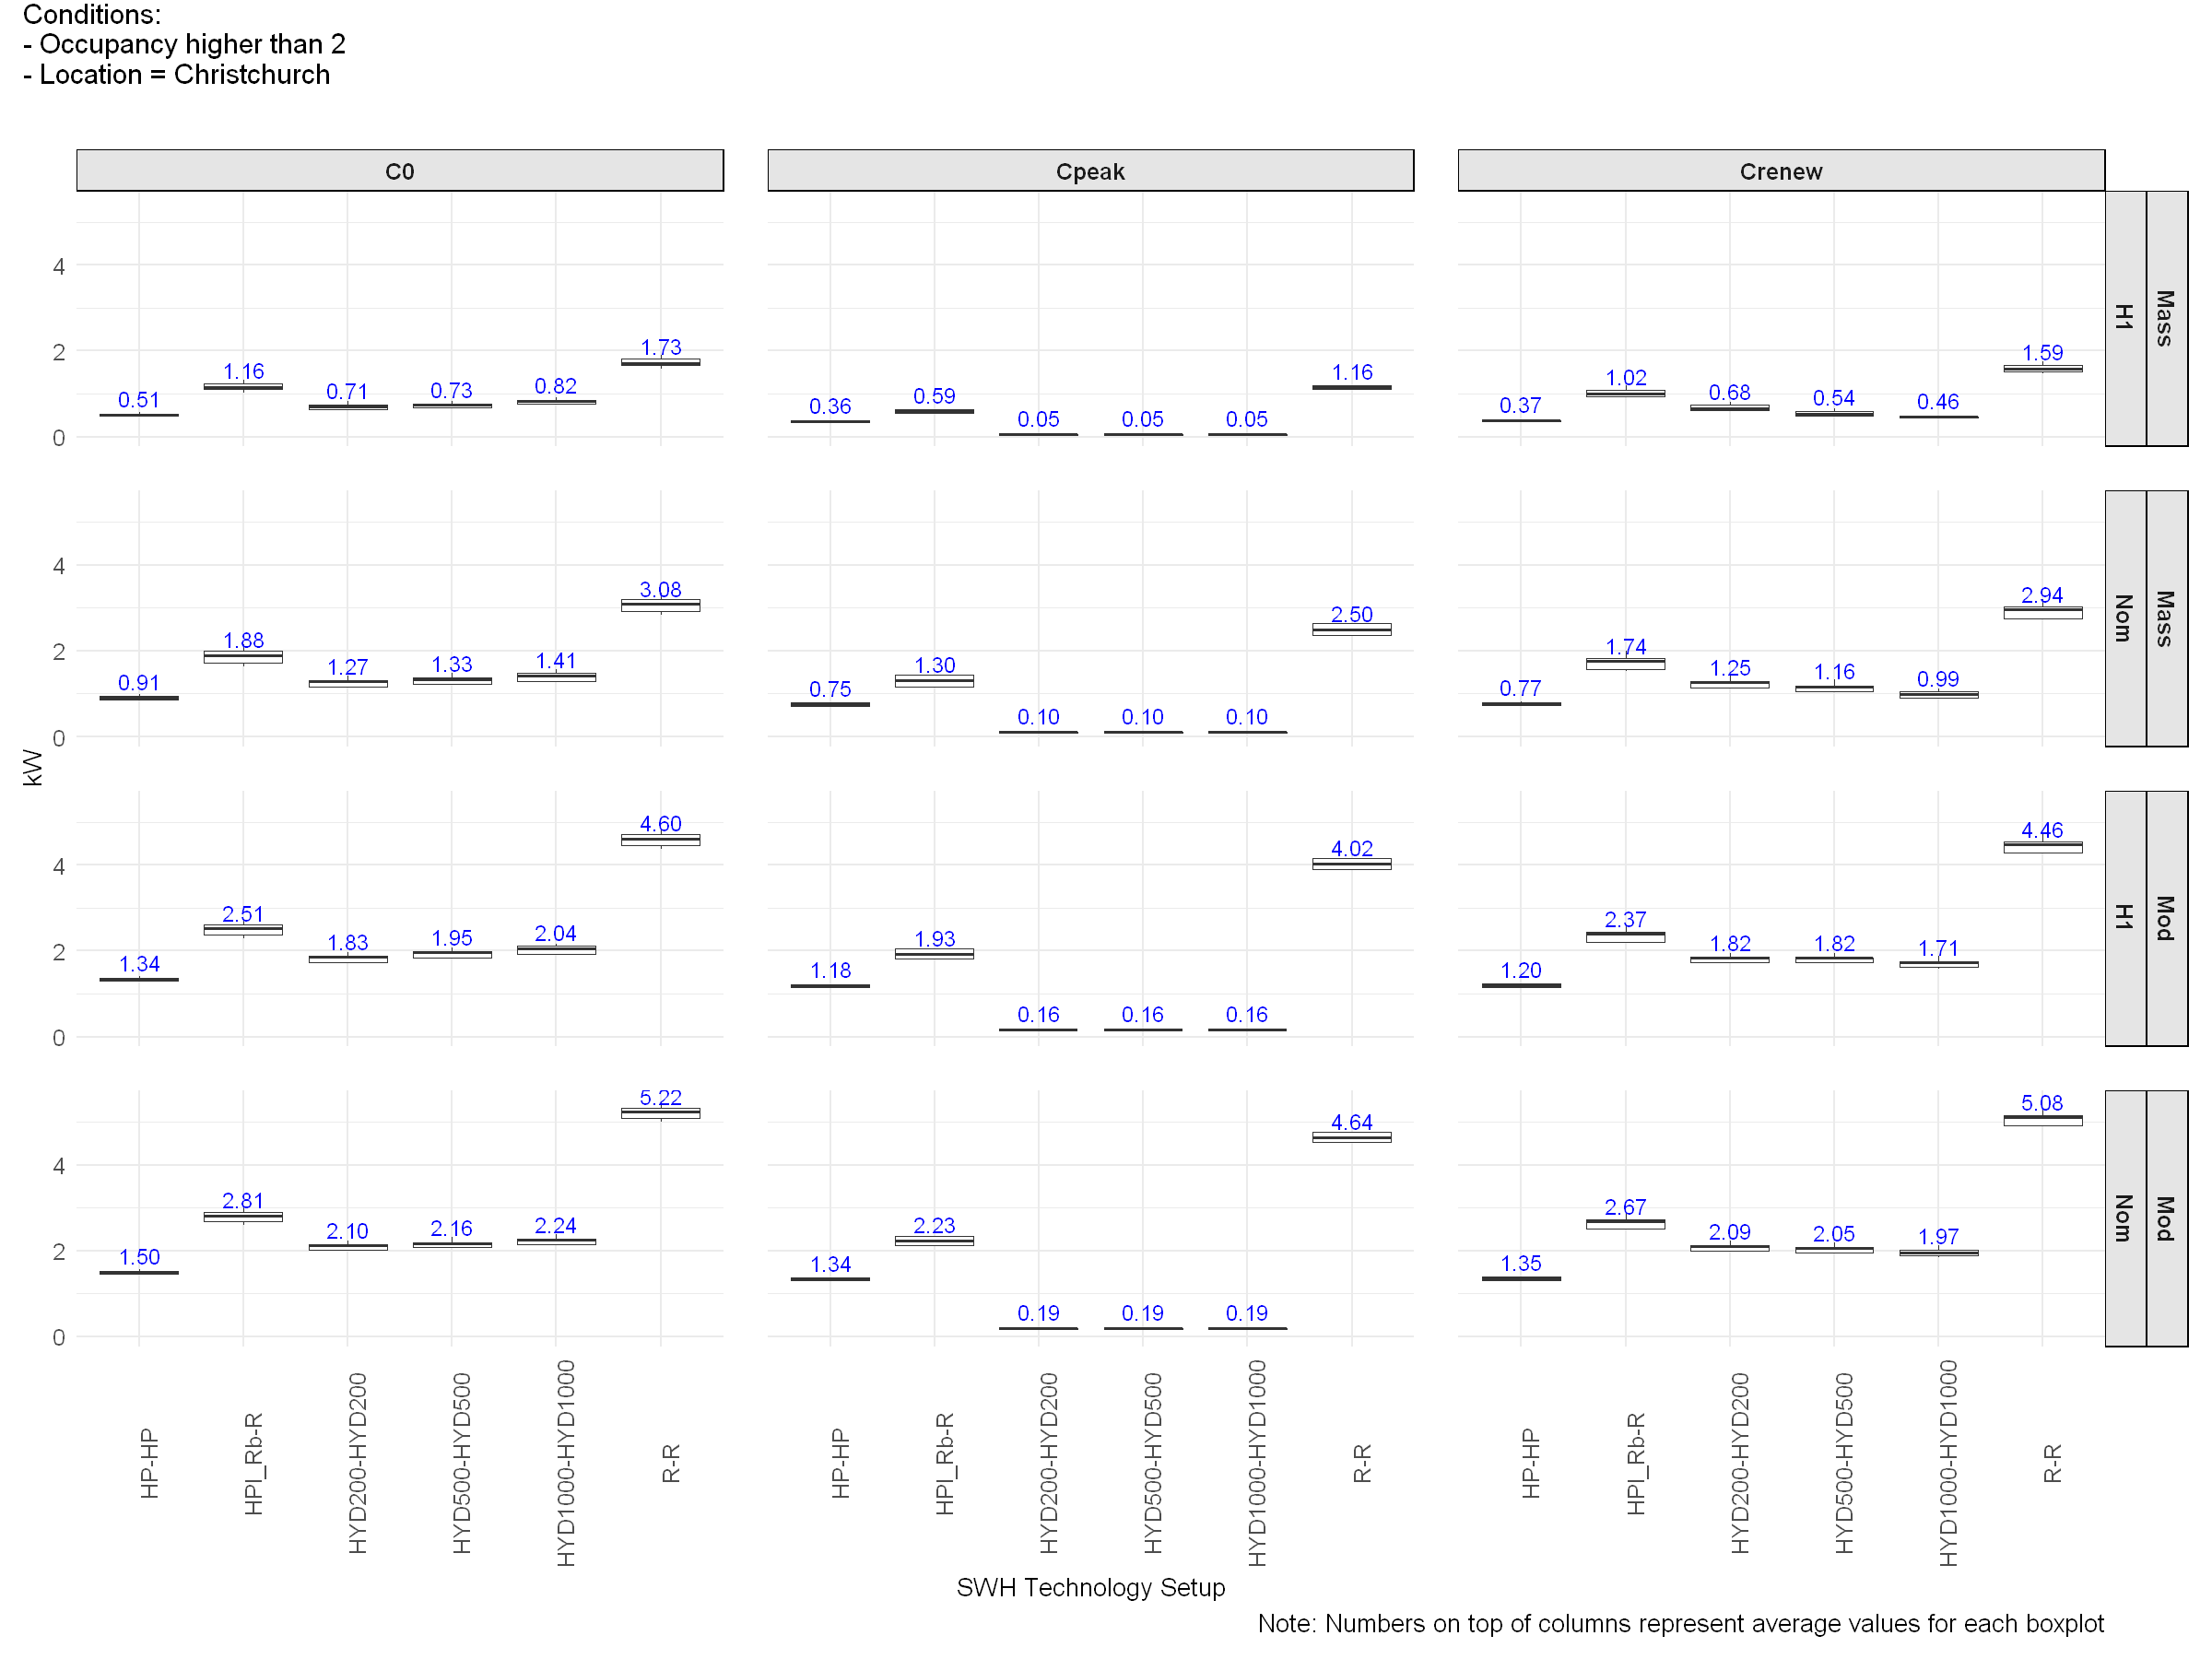

In [57]:
options(repr.plot.width=20, repr.plot.height=15)
main_plot <- household_lifetime_Call_CS_power %>%
  ggplot(aes(x = SH_DW_code, y = P_avg_peak_kW_year)) +
  geom_boxplot() +
  stat_summary(
    fun = mean, 
    geom = "text", 
    aes(label = sprintf("%.2f", after_stat(y))), 
    vjust = -0.5, 
    color = "blue", 
    size = 5
  ) +
  facet_grid(house_type + insulation ~ CS_code) +
  theme_minimal(base_size = 16) +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
    axis.text.y = element_text(size = 15),
    strip.text = element_text(face = "bold", size=15), 
    strip.background = element_rect(fill = "gray90", color = "black"),
    panel.spacing = unit(2, "lines"),
    plot.margin = margin(t = 30, r = 10, b = 10, l = 10),
    plot.caption = element_text(size = 16)
  ) +
    labs(caption = "Note: Numbers on top of columns represent average values for each boxplot",
        x = "SWH Technology Setup",
        y = "kW")
main_plot + 
  plot_annotation(
    title = "Conditions:\n- Occupancy higher than 2\n- Location = Christchurch",
    theme = theme(
      plot.title = element_text(size = 18, hjust = 0, vjust = 2)
    )
  )

The box plots above show the distribution of average power consumption during peak periods for various SWH configurations, highlighting the impact of different control signals. It can be observed that hydronic setups have the potential to significantly reduce SWH-related power demand compared to other configurations.
Assuming a typical household configuration includes a heat pump in living areas, electric resistive heaters in bedrooms, and a resistive hot water cylinder, hydronic systems could reduce peak power demand by approximately 1.1 to 2.6 kW per household. However, the aggregated effect on national power demand cannot be directly inferred from these figures, as it would require consideration of the diversity in household typologies, conditions, and geographic locations.
Furthermore, it would be valuable to explore the trade-offs between control signal strategies. Specifically, comparing whether the reduction in embodied emissions from power infrastructure—achieved by implementing a peak shaving control signal—outweighs the operational emissions reduction resulting from an intermittent-following control strategy.

## Breakdown of embedded emissions
The following plot shows a breakdown of embodied emissions which includes emissions associated to product manufacture, installation, distribution, end-of-life disposal and 'other' (B2-B5).

In [58]:
# Pivot longer to group lifecycle stages
radar_long <- household_lifetime_Call %>%
  filter(Occ_code == 3,
         SH_DW_code %in% c('HP-HP', 'R-R', 'HPl_Rb-R', 'HYD200-HYD200', 'HYD1000-HYD1000')) %>%
  select(house_type, insulation, SH_DW_code, Loc_code, 
         Manufacture, Distribution, Installation, EOL, Other) %>%
  distinct() %>%
  pivot_longer(
    cols = c(Manufacture, EOL, Other, Distribution, Installation),
    names_to = "Lifecycle_Stage",
    values_to = "Value"
  ) %>% # Order stages clockwise
  mutate(Lifecycle_Stage = factor(Lifecycle_Stage,
                                 levels = c("Manufacture", "EOL", "Distribution", "Installation",  "Other")))

common_max <- max(radar_long$Value) * 1.1  # 10% padding
mid_value <- common_max / 2
n_vars <- nlevels(radar_long$Lifecycle_Stage)
angles <- seq(0, 2*pi, length.out = n_vars + 1)[-(n_vars + 1)]  # Remove duplicate 360°

df_polygons <- radar_long %>%
  group_by(house_type, insulation, SH_DW_code, Loc_code) %>%
  arrange(Lifecycle_Stage) %>%
  mutate(
    angle = angles[as.numeric(Lifecycle_Stage)],
    x = Value * sin(angle),
    y = Value * cos(angle)
  ) %>%
  # Add first point again to close polygons
  group_modify(~ add_row(.x, .x[1,])) %>%
  ungroup()

scale_circles <- tibble(
  value = c(mid_value, common_max),
  label = c(round(mid_value, 1), round(common_max, 1))
) %>%
  expand_grid(
    angle = seq(0, 2*pi, length.out = 100)
  ) %>%
  mutate(
    x = value * sin(angle),
    y = value * cos(angle)
  )


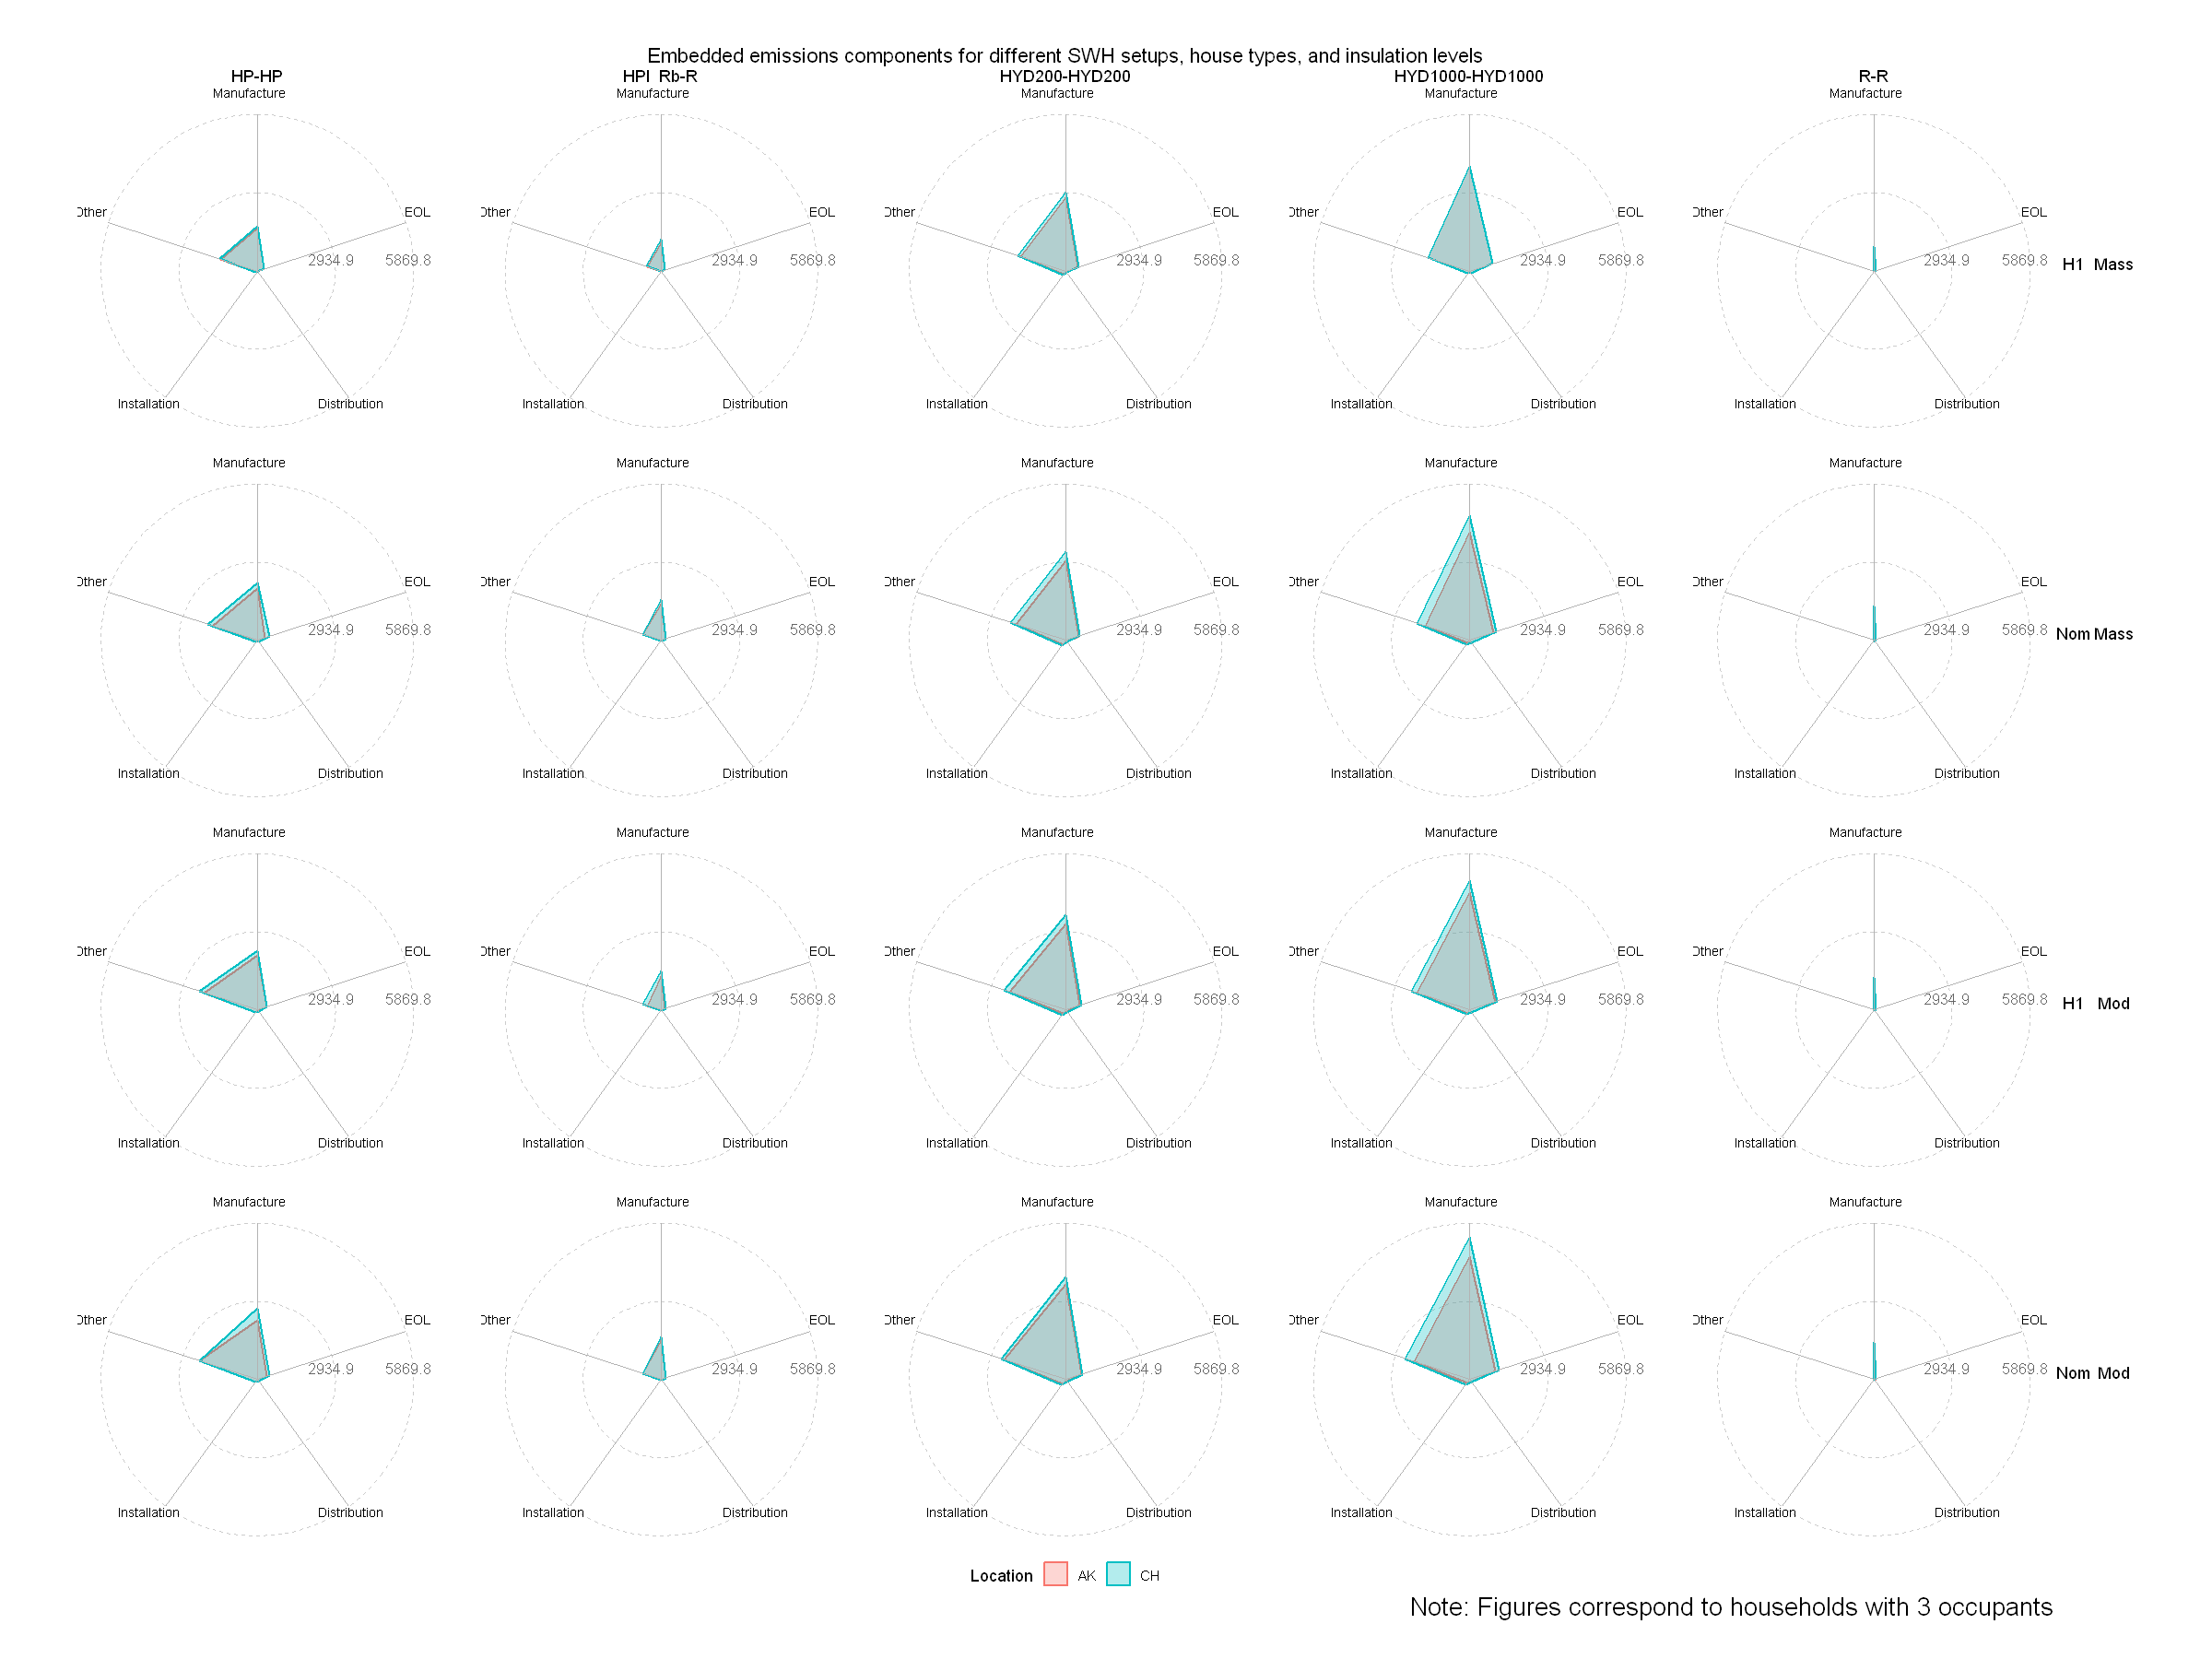

In [59]:
ggplot() +
  # Background scale circles
  geom_path(
    data = scale_circles,
    aes(x = x, y = y, group = value),
    color = "gray80",
    linetype = "dashed",
    size = 0.3
  ) +
  # Scale value labels
  geom_text(
    data = scale_circles %>% 
      filter(angle == 0) %>%
      distinct(value, label),
    aes(x = value, y = 0, label = label),
    hjust = 0.6,
    vjust = -0.5,
    size = 3.5,
    color = "gray40"
  ) +
  # Filled polygons 
  geom_polygon(
    data = df_polygons,
    aes(x = x, y = y, 
        group = interaction(Loc_code, house_type, insulation, SH_DW_code),
        fill = Loc_code,
        color = Loc_code),
    alpha = 0.3,  # Transparency
    size = 0.8
  ) +
  # Axis spokes
  geom_segment(
    data = data.frame(
      x = 0, y = 0,
      xend = common_max * sin(angles),
      yend = common_max * cos(angles)
    ),
    aes(x = x, y = y, xend = xend, yend = yend),
    color = "gray70",
    size = 0.3
  ) +
  # Axis labels
  geom_text(
    data = data.frame(
      x = 1.1 * common_max * sin(angles),
      y = 1.1 * common_max * cos(angles),
      label = levels(radar_long$Lifecycle_Stage)
    ),
    aes(x = x, y = y, label = label),
    hjust = 0.6,
    vjust = -0.2,  
    size = 3
  ) +
  facet_grid(
    rows = vars(house_type, insulation),
    cols = vars(SH_DW_code)
  ) +
  coord_fixed() +
  theme_void() +
  labs(
    title = "Embedded emissions components for different SWH setups, house types, and insulation levels",
    fill = "Location",
    color = "Location",
    caption = "Note: Figures correspond to households with 3 occupants"  
  ) +
  theme(
    legend.position = "bottom",
    strip.text = element_text(size = 11),
    plot.title = element_text(hjust = 0.5),
    plot.caption = element_text(size = 16),
    panel.spacing.x = unit(2, "lines"),   # Increased spacing between facets
    plot.margin = margin(25, 25, 25, 25)  # Add more space around the plot
  )

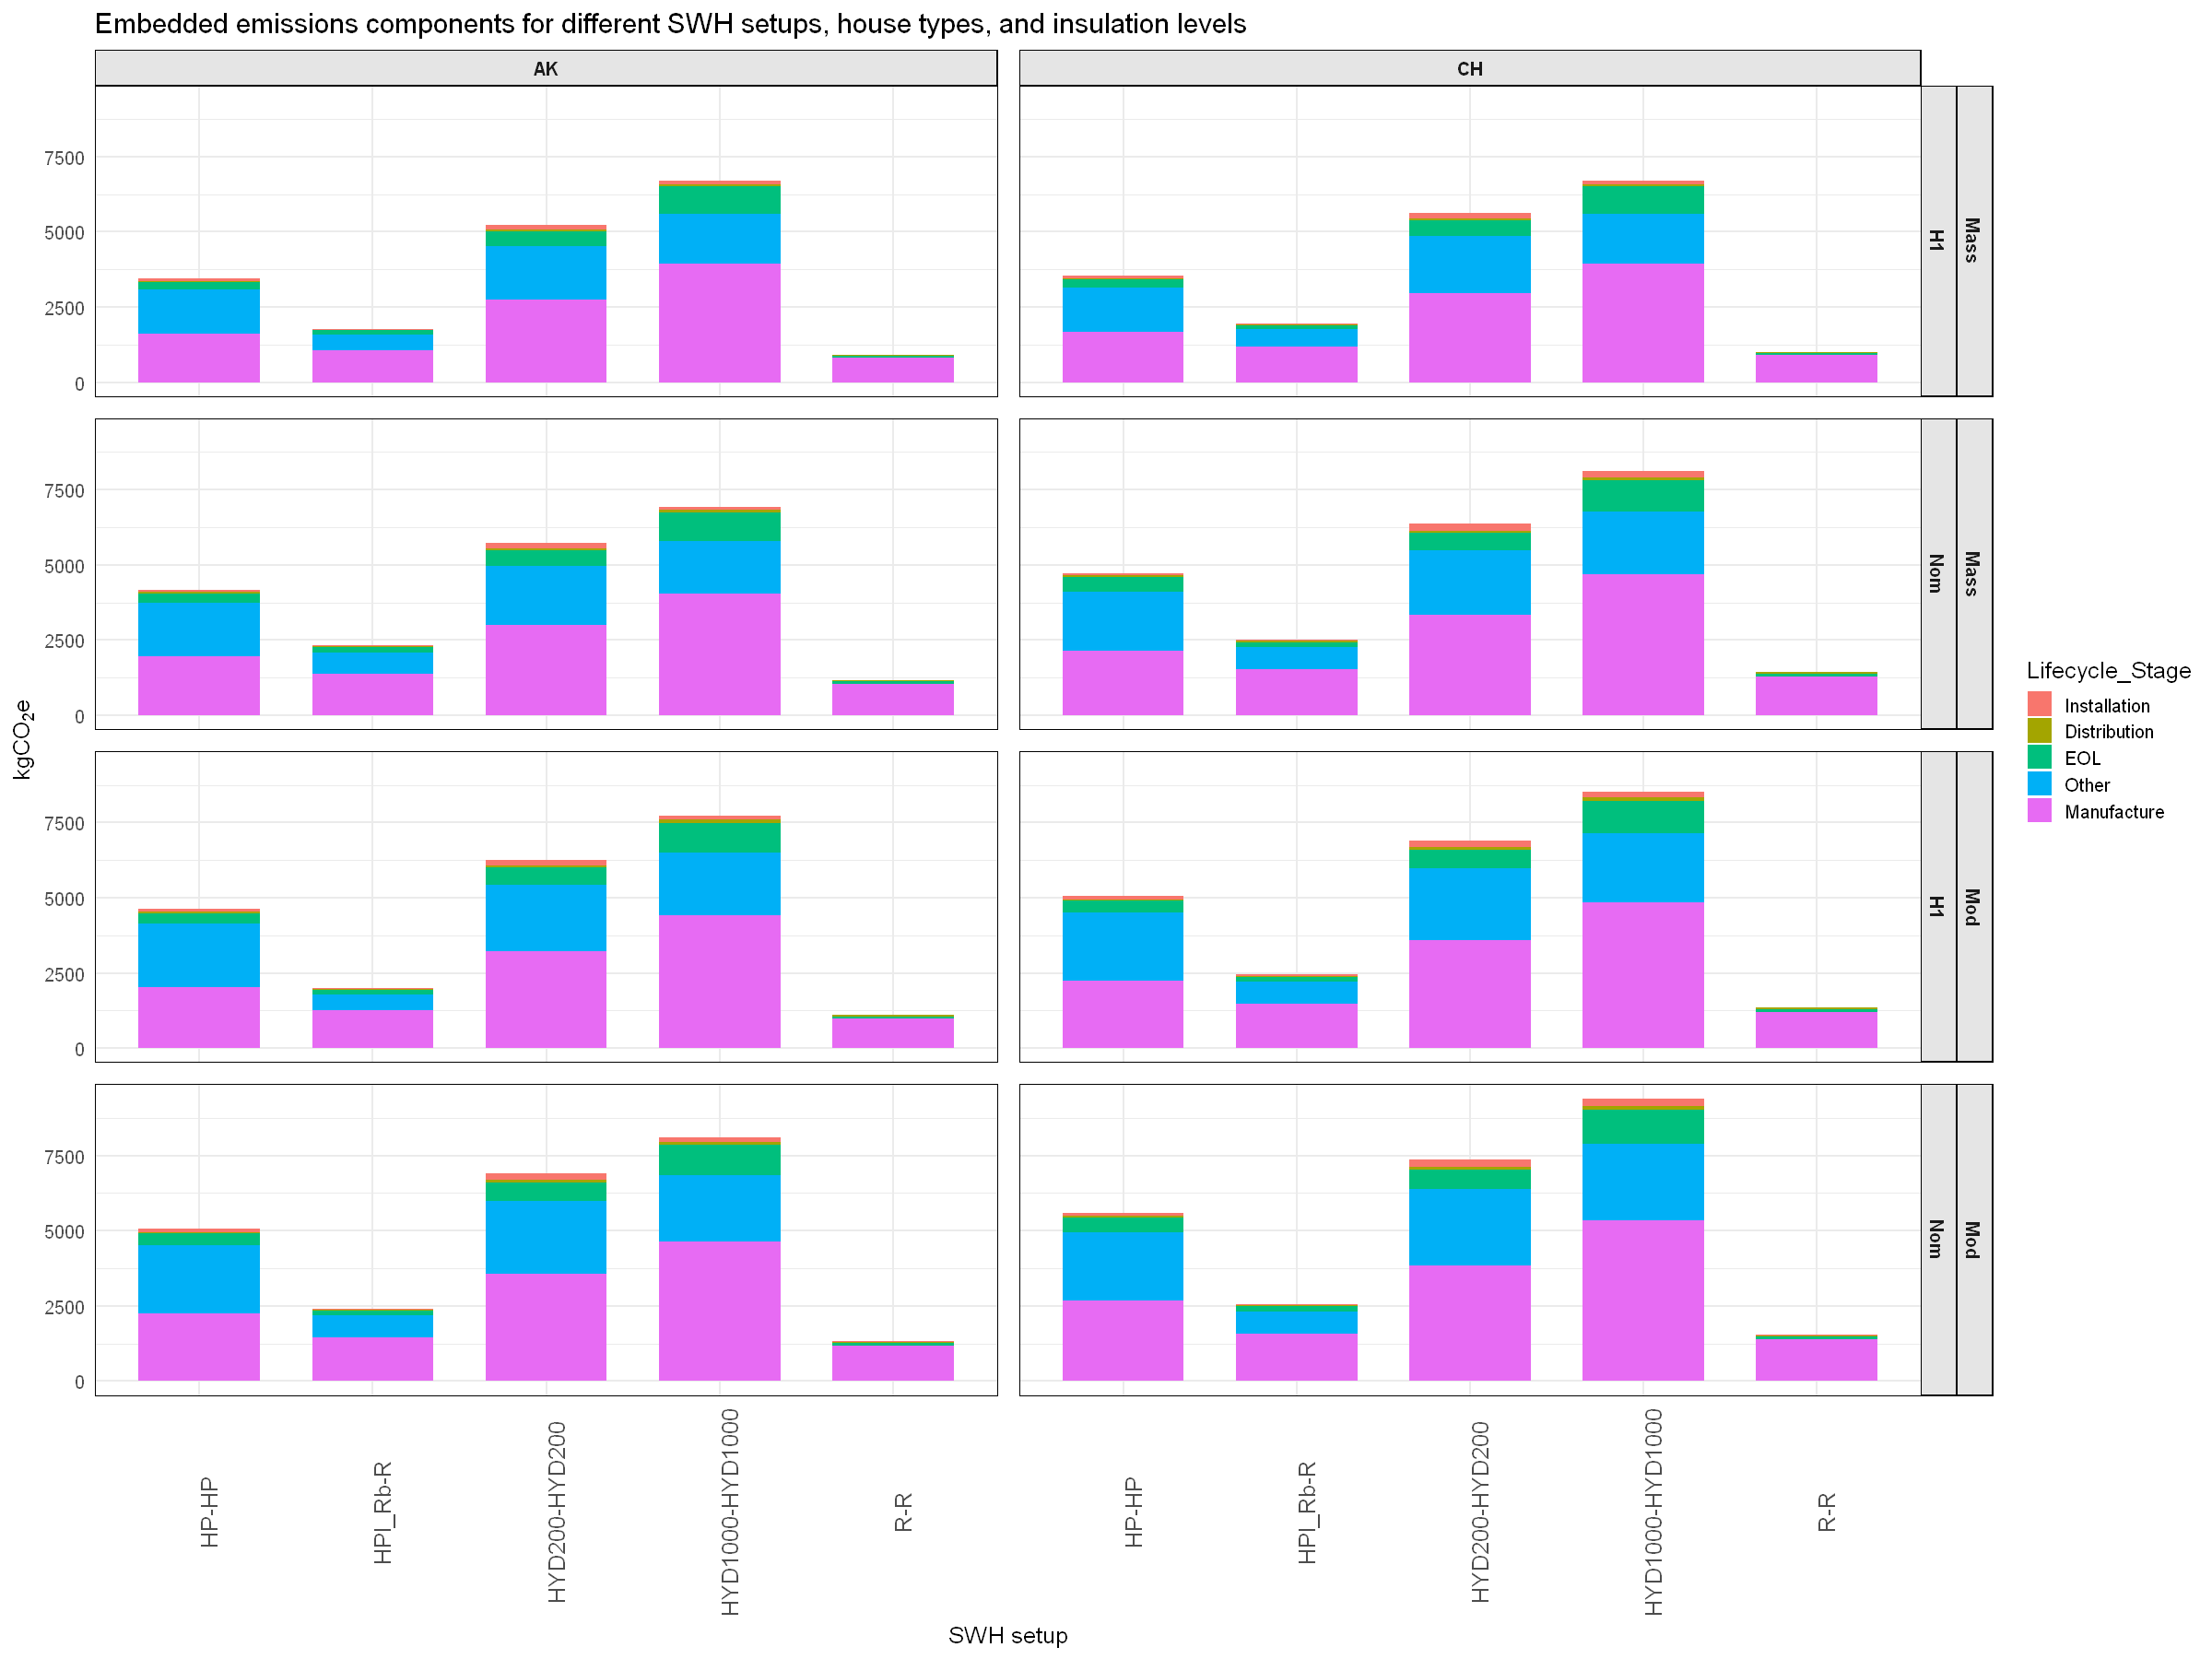

In [60]:
options(repr.plot.width=20, repr.plot.height=15)
radar_long %>% 
    mutate(Lifecycle_Stage = factor(Lifecycle_Stage,
                                 levels = c("Installation", "Distribution", "EOL", "Other", "Manufacture"))) %>%
    ggplot(aes(x = SH_DW_code, y = Value, fill = Lifecycle_Stage)) +
    geom_col(position = "stack", width = 0.7) +
    facet_grid(house_type + insulation ~ Loc_code) +
    theme_minimal(base_size = 15) +
    labs(x = "SWH setup",
       y = expression(kgCO[2]*e),
       title = "Embedded emissions components for different SWH setups, house types, and insulation levels",
      ) +
    theme(
        axis.text.x = element_text(angle = 90, hjust = 0.5, size = 15),
        strip.text = element_text(face = "bold"),
        strip.background = element_rect(fill = "gray90", color = "black"),
        panel.border = element_rect(color = "black", fill = NA, size = 0.1),
        panel.spacing = unit(1, "lines")
      )

### Discussion
The plots above shows the breakdown of embedded emissions across different locations, house types, and insulation levels:
- Hydronic settings have the highest embedded emissions of all combinations.
- All resistive setups have the lowest embedded emissions.
- Manufacturing embedded emissions dominate over all categories.